In [ ]:
import pandas as pd
import numpy as np
import random
import optuna
import json
from catboost import CatBoostRegressor

# 1. ГЛОБАЛЬНЫЕ НАСТРОЙКИ
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 2. ЗАГРУЗКА ДАННЫХ
print("Загрузка данных...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 3. FEATURE ENGINEERING
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        # Средние цены
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
        
        # СТАНДАРТНЫЕ ОТКЛОНЕНИЯ
        for col in ['management_group_id', 'first_category_id', 'third_category_id']:
            df[f'std_p05_{col}'] = df[col].map(train_ref.groupby(col)['price_p05'].std().to_dict())
            df[f'std_p95_{col}'] = df[col].map(train_ref.groupby(col)['price_p95'].std().to_dict())
            
    # Технические признаки
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

print("Создание признаков...")
train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

def add_cyclical_features(df):
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = ['management_group_id', 'first_category_id', 'activity_flag']
features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] 

std_cols = [c for c in train.columns if 'std_p' in c and 'dow' not in c and 'second' not in c]
features += std_cols + cat_features

# Заполнение пропусков
mean_values = train[features].mean(numeric_only=True)
train[features] = train[features].fillna(mean_values)
test[features] = test[features].fillna(mean_values)

# 5. ВАЛИДАЦИЯ
print("Подготовка валидационных наборов...")
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

def objective(trial):
    # --- МОДЕЛЬ НИЖНЕЙ ГРАНИЦЫ (L) ---
    params_low = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float("lr_l", 0.005, 0.2, log=True),
        'depth': trial.suggest_int("depth_l", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_l", 1.0, 20.0),
        'random_strength': trial.suggest_float("rs_l", 0.5, 3.0),
        'bagging_temperature': trial.suggest_float("bt_l", 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int("mdil_l", 1, 100),
        'random_seed': SEED,
        'verbose': False,
        'loss_function': 'MAE',
        'early_stopping_rounds': 150,
        'allow_writing_files': False
    }
    
    # --- МОДЕЛЬ ВЕРХНЕЙ ГРАНИЦЫ (H) ---
    params_high = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float("lr_h", 0.005, 0.2, log=True),
        'depth': trial.suggest_int("depth_h", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_h", 1.0, 20.0),
        'random_strength': trial.suggest_float("rs_h", 0.5, 3.0),
        'bagging_temperature': trial.suggest_float("bt_h", 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int("mdil_h", 1, 100),
        'random_seed': SEED,
        'verbose': False,
        'loss_function': 'MAE',
        'early_stopping_rounds': 150,
        'allow_writing_files': False
    }

    m_low = CatBoostRegressor(**params_low).fit(
        train_part[features], train_part['price_p05'], 
        eval_set=(val_part[features], val_part['price_p05']), 
        cat_features=cat_features
    )
    m_high = CatBoostRegressor(**params_high).fit(
        train_part[features], train_part['price_p95'], 
        eval_set=(val_part[features], val_part['price_p95']), 
        cat_features=cat_features
    )

    preds_l = m_low.predict(val_part[features])
    preds_h = m_high.predict(val_part[features])
    
    nonconf_low = preds_l - val_part['price_p05'].values
    nonconf_high = val_part['price_p95'].values - preds_h

    # Глобальный поиск альф внутри итерации
    best_iou = -1
    alphas = np.linspace(0.1, 0.9, 81)
    
    # Быстрый поиск (ql и qh считаем один раз во внешних циклах)
    qls = [np.quantile(nonconf_low, 1 - a/2) for a in alphas]
    qhs = [np.quantile(nonconf_high, 1 - a/2) for a in alphas]

    for i, ql in enumerate(qls):
        p05_c = preds_l - ql
        for j, qh in enumerate(qhs):
            p95_c = preds_h + qh
            p95_c_safe = np.maximum(p95_c, p05_c + 0.001)
            score = calculate_iou(val_part['price_p05'].values, val_part['price_p95'].values, p05_c, p95_c_safe)
            if score > best_iou:
                best_iou = score

    print(f"Trial {trial.number} finished with IoU: {best_iou:.4f}")
                
    return best_iou

# ЗАПУСК
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=16 * 3600, gc_after_trial=True)

# СОХРАНЕНИЕ
with open('best_params.json', 'w') as f:
    json.dump({"best_iou": study.best_value, "params": study.best_trial.params}, f, indent=4)

print("Параметры сохранены в best_params.json")

Загрузка данных...
Создание признаков...
Подготовка валидационных наборов...


[I 2025-12-21 18:49:28,379] A new study created in memory with name: no-name-0f663a92-330a-4500-a402-5bf4b4e24b96
[I 2025-12-21 18:50:28,080] Trial 0 finished with value: 0.2814533880116674 and parameters: {'lr_l': 0.04529031078649358, 'depth_l': 7, 'l2_l': 3.2419212081982356, 'rs_l': 2.0107932410710605, 'bt_l': 0.9425798542800923, 'mdil_l': 51, 'lr_h': 0.0051992464441724265, 'depth_h': 4, 'l2_h': 9.064535965778159, 'rs_h': 2.771748636925705, 'bt_h': 0.48397605656463505, 'mdil_h': 48}. Best is trial 0 with value: 0.2814533880116674.


Trial 0 finished with IoU: 0.2815


[I 2025-12-21 18:51:17,369] Trial 1 finished with value: 0.28326417954548533 and parameters: {'lr_l': 0.02116386807165325, 'depth_l': 5, 'l2_l': 4.315240212414407, 'rs_l': 2.509430274834168, 'bt_l': 0.8496072349732655, 'mdil_l': 62, 'lr_h': 0.009915534691728005, 'depth_h': 10, 'l2_h': 1.8839238296209255, 'rs_h': 1.054588035165711, 'bt_h': 0.5517145101509005, 'mdil_h': 20}. Best is trial 1 with value: 0.28326417954548533.


Trial 1 finished with IoU: 0.2833


[I 2025-12-21 18:52:34,159] Trial 2 finished with value: 0.28195434716165463 and parameters: {'lr_l': 0.006836171453301285, 'depth_l': 4, 'l2_l': 6.650813842934819, 'rs_l': 1.8271652142609667, 'bt_l': 0.6993147125298653, 'mdil_l': 31, 'lr_h': 0.00821928842333219, 'depth_h': 8, 'l2_h': 1.4931931745305216, 'rs_h': 2.9980803793160407, 'bt_h': 0.8327377577841549, 'mdil_h': 39}. Best is trial 1 with value: 0.28326417954548533.


Trial 2 finished with IoU: 0.2820


[I 2025-12-21 18:52:53,537] Trial 3 finished with value: 0.2806172424055517 and parameters: {'lr_l': 0.08793688088020467, 'depth_l': 6, 'l2_l': 5.733480597864288, 'rs_l': 2.123636916954659, 'bt_l': 0.10878035565352906, 'mdil_l': 46, 'lr_h': 0.038656659250434024, 'depth_h': 5, 'l2_h': 3.9176804171238717, 'rs_h': 1.9199948477263804, 'bt_h': 0.6846593479567534, 'mdil_h': 36}. Best is trial 1 with value: 0.28326417954548533.


Trial 3 finished with IoU: 0.2806


[I 2025-12-21 18:53:23,198] Trial 4 finished with value: 0.2830806195197296 and parameters: {'lr_l': 0.01326950552997361, 'depth_l': 6, 'l2_l': 6.3193212871758595, 'rs_l': 1.3333456932313232, 'bt_l': 0.4641397370968017, 'mdil_l': 34, 'lr_h': 0.11219319955901598, 'depth_h': 10, 'l2_h': 14.319210223685268, 'rs_h': 2.3616802178665335, 'bt_h': 0.8527676041442905, 'mdil_h': 82}. Best is trial 1 with value: 0.28326417954548533.


Trial 4 finished with IoU: 0.2831


[I 2025-12-21 18:53:56,068] Trial 5 finished with value: 0.28178093698484513 and parameters: {'lr_l': 0.10080470134574225, 'depth_l': 7, 'l2_l': 10.89540828210497, 'rs_l': 1.714645333057998, 'bt_l': 0.44429079128243887, 'mdil_l': 1, 'lr_h': 0.011624924528698118, 'depth_h': 10, 'l2_h': 9.81657688463761, 'rs_h': 1.9913351797878445, 'bt_h': 0.8438846855542796, 'mdil_h': 17}. Best is trial 1 with value: 0.28326417954548533.


Trial 5 finished with IoU: 0.2818


[I 2025-12-21 18:54:35,607] Trial 6 finished with value: 0.28072299323934813 and parameters: {'lr_l': 0.022901917868453924, 'depth_l': 7, 'l2_l': 9.858526935238588, 'rs_l': 1.301384661932265, 'bt_l': 0.6646717636013245, 'mdil_l': 9, 'lr_h': 0.054157162472403625, 'depth_h': 6, 'l2_h': 7.678665020266288, 'rs_h': 2.9005489518636653, 'bt_h': 0.24710208317372584, 'mdil_h': 70}. Best is trial 1 with value: 0.28326417954548533.


Trial 6 finished with IoU: 0.2807


[I 2025-12-21 18:55:36,896] Trial 7 finished with value: 0.28053495200213907 and parameters: {'lr_l': 0.009852193459107279, 'depth_l': 6, 'l2_l': 17.215812927562762, 'rs_l': 1.3273094197709594, 'bt_l': 0.4917480422533115, 'mdil_l': 33, 'lr_h': 0.06460908589993394, 'depth_h': 5, 'l2_h': 12.816405162423044, 'rs_h': 1.4412140096905244, 'bt_h': 0.18253609390152048, 'mdil_h': 2}. Best is trial 1 with value: 0.28326417954548533.


Trial 7 finished with IoU: 0.2805


[I 2025-12-21 18:57:04,947] Trial 8 finished with value: 0.2801291462324726 and parameters: {'lr_l': 0.005273930670784937, 'depth_l': 9, 'l2_l': 16.446371810265546, 'rs_l': 1.0721654402361518, 'bt_l': 0.04305667000999902, 'mdil_l': 28, 'lr_h': 0.1071103030165014, 'depth_h': 4, 'l2_h': 17.540632698704727, 'rs_h': 1.7703905111117, 'bt_h': 0.9946091993852122, 'mdil_h': 19}. Best is trial 1 with value: 0.28326417954548533.


Trial 8 finished with IoU: 0.2801


[I 2025-12-21 18:57:24,765] Trial 9 finished with value: 0.28116783705861526 and parameters: {'lr_l': 0.054890160092991185, 'depth_l': 7, 'l2_l': 7.484376791336833, 'rs_l': 0.8579710871839381, 'bt_l': 0.11618386247124013, 'mdil_l': 44, 'lr_h': 0.12169003752087636, 'depth_h': 8, 'l2_h': 6.998290911310738, 'rs_h': 2.5690058262746676, 'bt_h': 0.6297076240897161, 'mdil_h': 59}. Best is trial 1 with value: 0.28326417954548533.


Trial 9 finished with IoU: 0.2812


[I 2025-12-21 18:58:05,211] Trial 10 finished with value: 0.2819067072532219 and parameters: {'lr_l': 0.022716014459614905, 'depth_l': 4, 'l2_l': 1.5344055207164087, 'rs_l': 2.935922506919031, 'bt_l': 0.9647492680022172, 'mdil_l': 84, 'lr_h': 0.01717896710718058, 'depth_h': 8, 'l2_h': 1.0389435078479428, 'rs_h': 0.5712474477123095, 'bt_h': 0.008829704426555895, 'mdil_h': 1}. Best is trial 1 with value: 0.28326417954548533.


Trial 10 finished with IoU: 0.2819


[I 2025-12-21 18:58:51,909] Trial 11 finished with value: 0.28316931756858804 and parameters: {'lr_l': 0.013478525476380976, 'depth_l': 5, 'l2_l': 11.667420625443683, 'rs_l': 2.6984337332953783, 'bt_l': 0.34594578132891857, 'mdil_l': 73, 'lr_h': 0.0190088247622107, 'depth_h': 10, 'l2_h': 14.784967915868231, 'rs_h': 1.015675826174249, 'bt_h': 0.4961700846360608, 'mdil_h': 99}. Best is trial 1 with value: 0.28326417954548533.


Trial 11 finished with IoU: 0.2832


[I 2025-12-21 18:59:39,647] Trial 12 finished with value: 0.28167884151922407 and parameters: {'lr_l': 0.01293721584498001, 'depth_l': 5, 'l2_l': 12.63722710508922, 'rs_l': 2.76767909824304, 'bt_l': 0.3019358944851869, 'mdil_l': 77, 'lr_h': 0.021396884437713808, 'depth_h': 9, 'l2_h': 18.149640262004503, 'rs_h': 0.999578435341358, 'bt_h': 0.47738484452667906, 'mdil_h': 97}. Best is trial 1 with value: 0.28326417954548533.


Trial 12 finished with IoU: 0.2817


[I 2025-12-21 19:00:11,689] Trial 13 finished with value: 0.2833182040189483 and parameters: {'lr_l': 0.02561505495996883, 'depth_l': 10, 'l2_l': 13.017863663493031, 'rs_l': 2.476417712406264, 'bt_l': 0.7432499260578662, 'mdil_l': 69, 'lr_h': 0.019493888264972944, 'depth_h': 10, 'l2_h': 14.209870287122516, 'rs_h': 1.1814572709092392, 'bt_h': 0.394146928143833, 'mdil_h': 95}. Best is trial 13 with value: 0.2833182040189483.


Trial 13 finished with IoU: 0.2833


[I 2025-12-21 19:00:41,570] Trial 14 finished with value: 0.28267765185236193 and parameters: {'lr_l': 0.18302242460027282, 'depth_l': 10, 'l2_l': 19.71053270794389, 'rs_l': 2.3386275919490487, 'bt_l': 0.7698466811519431, 'mdil_l': 96, 'lr_h': 0.00923857026249865, 'depth_h': 9, 'l2_h': 12.040807120523406, 'rs_h': 1.2748846573635229, 'bt_h': 0.31459158615832195, 'mdil_h': 82}. Best is trial 13 with value: 0.2833182040189483.


Trial 14 finished with IoU: 0.2827


[I 2025-12-21 19:01:12,142] Trial 15 finished with value: 0.28349572645176097 and parameters: {'lr_l': 0.027667257390207867, 'depth_l': 9, 'l2_l': 15.139009086184647, 'rs_l': 2.3174289046682723, 'bt_l': 0.7706398789005594, 'mdil_l': 66, 'lr_h': 0.02997200334673646, 'depth_h': 9, 'l2_h': 6.00755498262153, 'rs_h': 0.5808385960011277, 'bt_h': 0.3727626563303213, 'mdil_h': 26}. Best is trial 15 with value: 0.28349572645176097.


Trial 15 finished with IoU: 0.2835


[I 2025-12-21 19:01:43,730] Trial 16 finished with value: 0.2809113917987778 and parameters: {'lr_l': 0.039620424390688476, 'depth_l': 9, 'l2_l': 14.84841084536027, 'rs_l': 2.314639828998649, 'bt_l': 0.6343205978191094, 'mdil_l': 60, 'lr_h': 0.030138802442265057, 'depth_h': 7, 'l2_h': 5.168780298655472, 'rs_h': 0.5133340325191187, 'bt_h': 0.369551480116484, 'mdil_h': 30}. Best is trial 15 with value: 0.28349572645176097.


Trial 16 finished with IoU: 0.2809


[I 2025-12-21 19:02:15,811] Trial 17 finished with value: 0.2804700140702208 and parameters: {'lr_l': 0.029647086199608992, 'depth_l': 10, 'l2_l': 14.435757368464792, 'rs_l': 0.5048870652417694, 'bt_l': 0.8176287190593772, 'mdil_l': 99, 'lr_h': 0.03308162595687408, 'depth_h': 9, 'l2_h': 15.594407066070127, 'rs_h': 0.7632457750812951, 'bt_h': 0.11612893765461829, 'mdil_h': 58}. Best is trial 15 with value: 0.28349572645176097.


Trial 17 finished with IoU: 0.2805


[I 2025-12-21 19:02:34,877] Trial 18 finished with value: 0.2815783705727087 and parameters: {'lr_l': 0.06855359301841436, 'depth_l': 9, 'l2_l': 19.82942852246111, 'rs_l': 1.7096569466819345, 'bt_l': 0.5843533849990117, 'mdil_l': 67, 'lr_h': 0.06360613809463483, 'depth_h': 7, 'l2_h': 11.60491398490974, 'rs_h': 1.444259205592706, 'bt_h': 0.37450144205342417, 'mdil_h': 80}. Best is trial 15 with value: 0.28349572645176097.


Trial 18 finished with IoU: 0.2816


[I 2025-12-21 19:02:56,552] Trial 19 finished with value: 0.2806582802999283 and parameters: {'lr_l': 0.03143951613441498, 'depth_l': 8, 'l2_l': 13.387793345001167, 'rs_l': 2.470849956309301, 'bt_l': 0.8883114062066728, 'mdil_l': 85, 'lr_h': 0.18791325792759545, 'depth_h': 9, 'l2_h': 5.460777432434172, 'rs_h': 0.8218899214931853, 'bt_h': 0.29969171222427515, 'mdil_h': 48}. Best is trial 15 with value: 0.28349572645176097.


Trial 19 finished with IoU: 0.2807


[I 2025-12-21 19:03:49,216] Trial 20 finished with value: 0.2827296423012351 and parameters: {'lr_l': 0.018132370932314047, 'depth_l': 10, 'l2_l': 8.98372452474561, 'rs_l': 2.0873716244092013, 'bt_l': 0.734359813223028, 'mdil_l': 56, 'lr_h': 0.013447382193644808, 'depth_h': 7, 'l2_h': 19.862340908331667, 'rs_h': 1.5093809993043068, 'bt_h': 0.09349999504058926, 'mdil_h': 69}. Best is trial 15 with value: 0.28349572645176097.


Trial 20 finished with IoU: 0.2827


[I 2025-12-21 19:04:42,604] Trial 21 finished with value: 0.2832294554296671 and parameters: {'lr_l': 0.01968561994950792, 'depth_l': 8, 'l2_l': 16.65048755375109, 'rs_l': 2.573959254906919, 'bt_l': 0.8436546222049562, 'mdil_l': 66, 'lr_h': 0.006054633694281109, 'depth_h': 10, 'l2_h': 2.389145209053451, 'rs_h': 1.1074595437243129, 'bt_h': 0.6119365358242406, 'mdil_h': 19}. Best is trial 15 with value: 0.28349572645176097.


Trial 21 finished with IoU: 0.2832


[I 2025-12-21 19:05:17,075] Trial 22 finished with value: 0.2819806272226497 and parameters: {'lr_l': 0.03030405771115583, 'depth_l': 8, 'l2_l': 3.68954498591081, 'rs_l': 2.9110584728505122, 'bt_l': 0.8725447515682875, 'mdil_l': 63, 'lr_h': 0.02712048924932138, 'depth_h': 10, 'l2_h': 3.4250285108457836, 'rs_h': 0.7657744939955905, 'bt_h': 0.4314424497493237, 'mdil_h': 29}. Best is trial 15 with value: 0.28349572645176097.


Trial 22 finished with IoU: 0.2820


[I 2025-12-21 19:06:34,587] Trial 23 finished with value: 0.2828098003719596 and parameters: {'lr_l': 0.008701198029078818, 'depth_l': 9, 'l2_l': 14.78849767388887, 'rs_l': 2.3187192026497248, 'bt_l': 0.5505955674874811, 'mdil_l': 77, 'lr_h': 0.013549171958258591, 'depth_h': 9, 'l2_h': 6.880813734746807, 'rs_h': 1.2197471172490002, 'bt_h': 0.5801864083647796, 'mdil_h': 12}. Best is trial 15 with value: 0.28349572645176097.


Trial 23 finished with IoU: 0.2828


[I 2025-12-21 19:07:44,465] Trial 24 finished with value: 0.28283606139743767 and parameters: {'lr_l': 0.01637976536826328, 'depth_l': 10, 'l2_l': 9.286349653784852, 'rs_l': 2.5648109374057215, 'bt_l': 0.992936140113388, 'mdil_l': 86, 'lr_h': 0.008080492496029514, 'depth_h': 8, 'l2_h': 5.0181487976318655, 'rs_h': 0.852158190790433, 'bt_h': 0.7244685991336857, 'mdil_h': 27}. Best is trial 15 with value: 0.28349572645176097.


Trial 24 finished with IoU: 0.2828


[I 2025-12-21 19:08:11,674] Trial 25 finished with value: 0.2823485697469103 and parameters: {'lr_l': 0.038406143124654395, 'depth_l': 5, 'l2_l': 18.06684939804125, 'rs_l': 1.8821273957113225, 'bt_l': 0.742073259207973, 'mdil_l': 53, 'lr_h': 0.04519213075815356, 'depth_h': 10, 'l2_h': 9.211716297307763, 'rs_h': 0.6050932386121265, 'bt_h': 0.5534592745528937, 'mdil_h': 42}. Best is trial 15 with value: 0.28349572645176097.


Trial 25 finished with IoU: 0.2823


[I 2025-12-21 19:08:46,616] Trial 26 finished with value: 0.2827779427325473 and parameters: {'lr_l': 0.024389740233135858, 'depth_l': 8, 'l2_l': 12.418895259052713, 'rs_l': 2.2346629580897654, 'bt_l': 0.8045205488580283, 'mdil_l': 72, 'lr_h': 0.02436770019517292, 'depth_h': 9, 'l2_h': 3.2029567191366928, 'rs_h': 1.6481109111348582, 'bt_h': 0.3899285079648421, 'mdil_h': 9}. Best is trial 15 with value: 0.28349572645176097.


Trial 26 finished with IoU: 0.2828


[I 2025-12-21 19:09:21,553] Trial 27 finished with value: 0.28118718277403004 and parameters: {'lr_l': 0.05483756760002857, 'depth_l': 9, 'l2_l': 7.920334769070362, 'rs_l': 2.7421331639468565, 'bt_l': 0.6122415657420164, 'mdil_l': 41, 'lr_h': 0.016272586775398116, 'depth_h': 10, 'l2_h': 13.437566648215242, 'rs_h': 1.2579527159456996, 'bt_h': 0.23866835521804203, 'mdil_h': 56}. Best is trial 15 with value: 0.28349572645176097.


Trial 27 finished with IoU: 0.2812


[I 2025-12-21 19:10:41,684] Trial 28 finished with value: 0.28317134901662216 and parameters: {'lr_l': 0.009851734503055777, 'depth_l': 10, 'l2_l': 4.565046648944452, 'rs_l': 2.485942775818758, 'bt_l': 0.9109179590036725, 'mdil_l': 58, 'lr_h': 0.010869221071399116, 'depth_h': 9, 'l2_h': 10.832126184732369, 'rs_h': 0.9475955487911593, 'bt_h': 0.7412680293232408, 'mdil_h': 23}. Best is trial 15 with value: 0.28349572645176097.


Trial 28 finished with IoU: 0.2832


[I 2025-12-21 19:11:26,470] Trial 29 finished with value: 0.28206899356282683 and parameters: {'lr_l': 0.04675333826974045, 'depth_l': 4, 'l2_l': 1.0067223560984075, 'rs_l': 1.9614492816932876, 'bt_l': 0.9341064303447956, 'mdil_l': 50, 'lr_h': 0.005390989319887133, 'depth_h': 8, 'l2_h': 16.07384547918657, 'rs_h': 0.6852861653768485, 'bt_h': 0.5390801759025767, 'mdil_h': 47}. Best is trial 15 with value: 0.28349572645176097.


Trial 29 finished with IoU: 0.2821


[I 2025-12-21 19:12:14,734] Trial 30 finished with value: 0.28292456368897084 and parameters: {'lr_l': 0.026514539540137477, 'depth_l': 6, 'l2_l': 14.081215743093232, 'rs_l': 1.6036186819186025, 'bt_l': 0.6878388681082047, 'mdil_l': 23, 'lr_h': 0.007262729359959843, 'depth_h': 10, 'l2_h': 7.596390193997623, 'rs_h': 1.1516489868180977, 'bt_h': 0.4618709749530268, 'mdil_h': 11}. Best is trial 15 with value: 0.28349572645176097.


Trial 30 finished with IoU: 0.2829


[I 2025-12-21 19:13:14,043] Trial 31 finished with value: 0.28456872928089555 and parameters: {'lr_l': 0.017904778586563964, 'depth_l': 8, 'l2_l': 15.939511610833552, 'rs_l': 2.6095998076151252, 'bt_l': 0.8425373345276153, 'mdil_l': 66, 'lr_h': 0.005468619414297228, 'depth_h': 10, 'l2_h': 2.3033431855713125, 'rs_h': 1.1622114451693806, 'bt_h': 0.6127035048126402, 'mdil_h': 34}. Best is trial 31 with value: 0.28456872928089555.


Trial 31 finished with IoU: 0.2846


[I 2025-12-21 19:14:17,785] Trial 32 finished with value: 0.2828579191970593 and parameters: {'lr_l': 0.016173827117417383, 'depth_l': 9, 'l2_l': 15.742065566908778, 'rs_l': 2.997638871361175, 'bt_l': 0.796643267621085, 'mdil_l': 70, 'lr_h': 0.006604533802594501, 'depth_h': 10, 'l2_h': 2.110487953059245, 'rs_h': 1.4021829044665264, 'bt_h': 0.6673943915774868, 'mdil_h': 34}. Best is trial 31 with value: 0.28456872928089555.


Trial 32 finished with IoU: 0.2829


[I 2025-12-21 19:15:29,426] Trial 33 finished with value: 0.2819081554636085 and parameters: {'lr_l': 0.019660302742926312, 'depth_l': 8, 'l2_l': 18.416971989841162, 'rs_l': 2.146990196133511, 'bt_l': 0.7157248891974138, 'mdil_l': 78, 'lr_h': 0.0051125862007941015, 'depth_h': 9, 'l2_h': 4.238670673394218, 'rs_h': 2.121043849545466, 'bt_h': 0.4203746958612508, 'mdil_h': 39}. Best is trial 31 with value: 0.28456872928089555.


Trial 33 finished with IoU: 0.2819


[I 2025-12-21 19:16:04,713] Trial 34 finished with value: 0.2835488620624828 and parameters: {'lr_l': 0.03725858993619751, 'depth_l': 7, 'l2_l': 11.155095355117291, 'rs_l': 2.4201090378037318, 'bt_l': 0.875167645803223, 'mdil_l': 63, 'lr_h': 0.01011615535840982, 'depth_h': 10, 'l2_h': 2.411517370393026, 'rs_h': 1.7312097602195835, 'bt_h': 0.5223703527273801, 'mdil_h': 43}. Best is trial 31 with value: 0.28456872928089555.


Trial 34 finished with IoU: 0.2835


[I 2025-12-21 19:16:39,581] Trial 35 finished with value: 0.28321838658169757 and parameters: {'lr_l': 0.03884079653094489, 'depth_l': 7, 'l2_l': 11.164791553204386, 'rs_l': 2.4217027914103775, 'bt_l': 0.8632744183168449, 'mdil_l': 92, 'lr_h': 0.014156238625859451, 'depth_h': 10, 'l2_h': 6.095399932622982, 'rs_h': 1.7224957494416733, 'bt_h': 0.3291939189367081, 'mdil_h': 42}. Best is trial 31 with value: 0.28456872928089555.


Trial 35 finished with IoU: 0.2832


[I 2025-12-21 19:17:27,153] Trial 36 finished with value: 0.2807086918231418 and parameters: {'lr_l': 0.07953416012117447, 'depth_l': 8, 'l2_l': 13.297736921261139, 'rs_l': 2.6597786445056473, 'bt_l': 0.9915492376781354, 'mdil_l': 49, 'lr_h': 0.008653707276162801, 'depth_h': 9, 'l2_h': 2.665083154596934, 'rs_h': 2.283368345011807, 'bt_h': 0.5313810989022384, 'mdil_h': 90}. Best is trial 31 with value: 0.28456872928089555.


Trial 36 finished with IoU: 0.2807


[I 2025-12-21 19:17:49,103] Trial 37 finished with value: 0.28096990815478307 and parameters: {'lr_l': 0.13115239362264672, 'depth_l': 9, 'l2_l': 11.919654165273922, 'rs_l': 2.195999284413254, 'bt_l': 0.9221158431585241, 'mdil_l': 61, 'lr_h': 0.03816906152945494, 'depth_h': 8, 'l2_h': 4.18390798223395, 'rs_h': 1.9357172015877522, 'bt_h': 0.7529441445643046, 'mdil_h': 53}. Best is trial 31 with value: 0.28456872928089555.


Trial 37 finished with IoU: 0.2810


[I 2025-12-21 19:18:20,589] Trial 38 finished with value: 0.2809133863684696 and parameters: {'lr_l': 0.04825888501987326, 'depth_l': 7, 'l2_l': 10.288495358747783, 'rs_l': 2.818947712361232, 'bt_l': 0.6697836096285386, 'mdil_l': 66, 'lr_h': 0.02228639245443001, 'depth_h': 10, 'l2_h': 8.211001051733806, 'rs_h': 1.6684083994323489, 'bt_h': 0.2309337428545718, 'mdil_h': 64}. Best is trial 31 with value: 0.28456872928089555.


Trial 38 finished with IoU: 0.2809


[I 2025-12-21 19:19:15,951] Trial 39 finished with value: 0.2815147913860072 and parameters: {'lr_l': 0.035799494956431886, 'depth_l': 8, 'l2_l': 15.624448444241121, 'rs_l': 1.987219154949701, 'bt_l': 0.7699592921658673, 'mdil_l': 81, 'lr_h': 0.011112080960434456, 'depth_h': 6, 'l2_h': 1.3848224225741532, 'rs_h': 2.0831025803113423, 'bt_h': 0.7938148609445053, 'mdil_h': 34}. Best is trial 31 with value: 0.28456872928089555.


Trial 39 finished with IoU: 0.2815


[I 2025-12-21 19:19:54,522] Trial 40 finished with value: 0.28378500141020396 and parameters: {'lr_l': 0.02654954989892551, 'depth_l': 7, 'l2_l': 13.245925120014835, 'rs_l': 1.5220558226576963, 'bt_l': 0.523277876574159, 'mdil_l': 40, 'lr_h': 0.006997185495717959, 'depth_h': 10, 'l2_h': 10.047945592817431, 'rs_h': 1.8469950301414269, 'bt_h': 0.6378946584581907, 'mdil_h': 24}. Best is trial 31 with value: 0.28456872928089555.


Trial 40 finished with IoU: 0.2838


[I 2025-12-21 19:20:35,954] Trial 41 finished with value: 0.28301989445318193 and parameters: {'lr_l': 0.024531042823709673, 'depth_l': 7, 'l2_l': 13.514449346237276, 'rs_l': 1.5608415598832102, 'bt_l': 0.2783620377049029, 'mdil_l': 39, 'lr_h': 0.006950960748939361, 'depth_h': 10, 'l2_h': 10.060777447358802, 'rs_h': 1.844060217719512, 'bt_h': 0.6691961278975419, 'mdil_h': 25}. Best is trial 31 with value: 0.28456872928089555.


Trial 41 finished with IoU: 0.2830


[I 2025-12-21 19:21:42,096] Trial 42 finished with value: 0.2813492986904793 and parameters: {'lr_l': 0.014567545448272818, 'depth_l': 7, 'l2_l': 15.605009563481516, 'rs_l': 1.4221368306830628, 'bt_l': 0.410399818721422, 'mdil_l': 55, 'lr_h': 0.009904461798664752, 'depth_h': 10, 'l2_h': 9.160644293540539, 'rs_h': 2.2933049441598867, 'bt_h': 0.8942197857955936, 'mdil_h': 45}. Best is trial 31 with value: 0.28456872928089555.


Trial 42 finished with IoU: 0.2813


[I 2025-12-21 19:22:25,373] Trial 43 finished with value: 0.28164917823142216 and parameters: {'lr_l': 0.02728540588048699, 'depth_l': 6, 'l2_l': 17.410011863193375, 'rs_l': 1.095883477877441, 'bt_l': 0.5755394617628314, 'mdil_l': 26, 'lr_h': 0.007911470660792676, 'depth_h': 10, 'l2_h': 13.31882275747964, 'rs_h': 1.6080877739941033, 'bt_h': 0.6138082291181517, 'mdil_h': 33}. Best is trial 31 with value: 0.28456872928089555.


Trial 43 finished with IoU: 0.2816


[I 2025-12-21 19:23:59,585] Trial 44 finished with value: 0.28252237383945755 and parameters: {'lr_l': 0.010932342469376684, 'depth_l': 7, 'l2_l': 10.820398018891003, 'rs_l': 2.621785109675646, 'bt_l': 0.5418162249675236, 'mdil_l': 44, 'lr_h': 0.006363635630244931, 'depth_h': 9, 'l2_h': 6.422334926132006, 'rs_h': 1.5379516400340323, 'bt_h': 0.45677362469413196, 'mdil_h': 14}. Best is trial 31 with value: 0.28456872928089555.


Trial 44 finished with IoU: 0.2825


[I 2025-12-21 19:24:20,400] Trial 45 finished with value: 0.2833222640096082 and parameters: {'lr_l': 0.06006546329867461, 'depth_l': 6, 'l2_l': 12.587042240852886, 'rs_l': 2.3839187863125364, 'bt_l': 0.1691239206148536, 'mdil_l': 18, 'lr_h': 0.01902070473483051, 'depth_h': 10, 'l2_h': 4.420982561065333, 'rs_h': 2.540830018707331, 'bt_h': 0.5125677287574225, 'mdil_h': 38}. Best is trial 31 with value: 0.28456872928089555.


Trial 45 finished with IoU: 0.2833


[I 2025-12-21 19:24:52,368] Trial 46 finished with value: 0.28005238787232406 and parameters: {'lr_l': 0.06962423564514206, 'depth_l': 6, 'l2_l': 12.01612081210375, 'rs_l': 1.8272769865324978, 'bt_l': 0.21309144272900815, 'mdil_l': 19, 'lr_h': 0.01520187994468703, 'depth_h': 4, 'l2_h': 4.594767618863553, 'rs_h': 2.73891687587908, 'bt_h': 0.5905016934932145, 'mdil_h': 37}. Best is trial 31 with value: 0.28456872928089555.


Trial 46 finished with IoU: 0.2801


[I 2025-12-21 19:25:18,601] Trial 47 finished with value: 0.2824395980979375 and parameters: {'lr_l': 0.1141263164089319, 'depth_l': 6, 'l2_l': 14.032299253727404, 'rs_l': 2.833863993158628, 'bt_l': 0.03901384075549494, 'mdil_l': 10, 'lr_h': 0.012412805299802057, 'depth_h': 9, 'l2_h': 3.403387260500721, 'rs_h': 2.3985319775156695, 'bt_h': 0.5405721985054582, 'mdil_h': 22}. Best is trial 31 with value: 0.28456872928089555.


Trial 47 finished with IoU: 0.2824


[I 2025-12-21 19:26:13,218] Trial 48 finished with value: 0.28190794413386183 and parameters: {'lr_l': 0.05472014164152999, 'depth_l': 6, 'l2_l': 16.338426961334477, 'rs_l': 2.1053868919593404, 'bt_l': 0.15623878927564672, 'mdil_l': 15, 'lr_h': 0.005611218426523669, 'depth_h': 10, 'l2_h': 5.592517981726519, 'rs_h': 2.607114519910354, 'bt_h': 0.5029007108709945, 'mdil_h': 6}. Best is trial 31 with value: 0.28456872928089555.


Trial 48 finished with IoU: 0.2819


[I 2025-12-21 19:26:45,665] Trial 49 finished with value: 0.28247535121304296 and parameters: {'lr_l': 0.0435117747335612, 'depth_l': 5, 'l2_l': 15.233347853445952, 'rs_l': 2.3895633673354117, 'bt_l': 0.4366952650229151, 'mdil_l': 2, 'lr_h': 0.017419027801494062, 'depth_h': 10, 'l2_h': 1.5772007429604735, 'rs_h': 2.8754398014344034, 'bt_h': 0.6484464889689686, 'mdil_h': 42}. Best is trial 31 with value: 0.28456872928089555.


Trial 49 finished with IoU: 0.2825


[I 2025-12-21 19:27:13,948] Trial 50 finished with value: 0.2817763970453053 and parameters: {'lr_l': 0.034642972283652436, 'depth_l': 7, 'l2_l': 11.477809120941847, 'rs_l': 1.1175650753115138, 'bt_l': 0.3703579168345479, 'mdil_l': 36, 'lr_h': 0.04585685866818369, 'depth_h': 9, 'l2_h': 2.837541450084183, 'rs_h': 1.346415594852108, 'bt_h': 0.71663357302177, 'mdil_h': 51}. Best is trial 31 with value: 0.28456872928089555.


Trial 50 finished with IoU: 0.2818


[I 2025-12-21 19:28:00,550] Trial 51 finished with value: 0.28186992775314657 and parameters: {'lr_l': 0.020933987019576276, 'depth_l': 10, 'l2_l': 13.066515774066769, 'rs_l': 2.2237389455779697, 'bt_l': 0.8398509371182528, 'mdil_l': 70, 'lr_h': 0.03161617582504799, 'depth_h': 10, 'l2_h': 8.096030071610011, 'rs_h': 1.8572371121518216, 'bt_h': 0.4211942356878861, 'mdil_h': 31}. Best is trial 31 with value: 0.28456872928089555.


Trial 51 finished with IoU: 0.2819


[I 2025-12-21 19:28:37,065] Trial 52 finished with value: 0.28258880102750217 and parameters: {'lr_l': 0.033188615541491474, 'depth_l': 9, 'l2_l': 12.62420287992499, 'rs_l': 2.291808886677891, 'bt_l': 0.7609060861758024, 'mdil_l': 65, 'lr_h': 0.0189744616502335, 'depth_h': 10, 'l2_h': 11.429758078910922, 'rs_h': 2.0882165169880262, 'bt_h': 0.34901436343349496, 'mdil_h': 38}. Best is trial 31 with value: 0.28456872928089555.


Trial 52 finished with IoU: 0.2826


[I 2025-12-21 19:29:03,379] Trial 53 finished with value: 0.2813239940509751 and parameters: {'lr_l': 0.0614868445625069, 'depth_l': 8, 'l2_l': 9.957919409306813, 'rs_l': 2.484381879370644, 'bt_l': 0.6444626269171083, 'mdil_l': 74, 'lr_h': 0.024796028918496006, 'depth_h': 9, 'l2_h': 1.038921267793433, 'rs_h': 2.5683162634149292, 'bt_h': 0.2993603700332814, 'mdil_h': 17}. Best is trial 31 with value: 0.28456872928089555.


Trial 53 finished with IoU: 0.2813


[I 2025-12-21 19:30:00,392] Trial 54 finished with value: 0.2818885546725779 and parameters: {'lr_l': 0.02236896408522298, 'depth_l': 7, 'l2_l': 14.408464741171946, 'rs_l': 2.6512386513528106, 'bt_l': 0.514437187018318, 'mdil_l': 59, 'lr_h': 0.010220478975555312, 'depth_h': 10, 'l2_h': 3.7919859650691317, 'rs_h': 0.8938345382803398, 'bt_h': 0.5096504510019415, 'mdil_h': 28}. Best is trial 31 with value: 0.28456872928089555.


Trial 54 finished with IoU: 0.2819


[I 2025-12-21 19:30:33,972] Trial 55 finished with value: 0.28277884164970407 and parameters: {'lr_l': 0.026774081363738537, 'depth_l': 9, 'l2_l': 8.999628832934164, 'rs_l': 2.545093770026471, 'bt_l': 0.8193134290419637, 'mdil_l': 47, 'lr_h': 0.036737072687617556, 'depth_h': 10, 'l2_h': 14.842089924742652, 'rs_h': 1.0807588017805272, 'bt_h': 0.3953591329342098, 'mdil_h': 93}. Best is trial 31 with value: 0.28456872928089555.


Trial 55 finished with IoU: 0.2828


[I 2025-12-21 19:31:31,992] Trial 56 finished with value: 0.2828715327525937 and parameters: {'lr_l': 0.016335128720962423, 'depth_l': 8, 'l2_l': 13.675764816718598, 'rs_l': 1.499390377158502, 'bt_l': 0.08375505965226027, 'mdil_l': 53, 'lr_h': 0.020127837362742505, 'depth_h': 9, 'l2_h': 2.121260924327346, 'rs_h': 0.6665044857360101, 'bt_h': 0.45732651387120027, 'mdil_h': 74}. Best is trial 31 with value: 0.28456872928089555.


Trial 56 finished with IoU: 0.2829


[I 2025-12-21 19:31:53,894] Trial 57 finished with value: 0.28137898877325107 and parameters: {'lr_l': 0.04423930276670379, 'depth_l': 10, 'l2_l': 16.404048923925625, 'rs_l': 2.3841499221825475, 'bt_l': 0.49044827167703037, 'mdil_l': 30, 'lr_h': 0.08309429818946446, 'depth_h': 6, 'l2_h': 16.302181752633533, 'rs_h': 1.3383087396294169, 'bt_h': 0.5911073539518908, 'mdil_h': 25}. Best is trial 31 with value: 0.28456872928089555.


Trial 57 finished with IoU: 0.2814


[I 2025-12-21 19:32:15,741] Trial 58 finished with value: 0.28315789024162075 and parameters: {'lr_l': 0.09249219067872563, 'depth_l': 7, 'l2_l': 8.044711647421178, 'rs_l': 1.7706885717229324, 'bt_l': 0.9597696725282663, 'mdil_l': 63, 'lr_h': 0.02898068899990158, 'depth_h': 10, 'l2_h': 18.26676023635745, 'rs_h': 1.1814221310000423, 'bt_h': 0.5636331233484138, 'mdil_h': 20}. Best is trial 31 with value: 0.28456872928089555.


Trial 58 finished with IoU: 0.2832


[I 2025-12-21 19:33:05,645] Trial 59 finished with value: 0.28237098766082996 and parameters: {'lr_l': 0.029795921019404748, 'depth_l': 5, 'l2_l': 18.7438612725978, 'rs_l': 1.2069610427528727, 'bt_l': 0.8835257565520849, 'mdil_l': 69, 'lr_h': 0.009028994854060534, 'depth_h': 8, 'l2_h': 4.842763318635111, 'rs_h': 2.1931688922527295, 'bt_h': 0.49247113474393306, 'mdil_h': 62}. Best is trial 31 with value: 0.28456872928089555.


Trial 59 finished with IoU: 0.2824


[I 2025-12-21 20:32:46,371] Trial 60 finished with value: 0.28217475452445717 and parameters: {'lr_l': 0.011395137027742329, 'depth_l': 6, 'l2_l': 12.870237783593788, 'rs_l': 2.0419550433164635, 'bt_l': 0.006693763162411881, 'mdil_l': 75, 'lr_h': 0.007667376510724374, 'depth_h': 9, 'l2_h': 12.486669547647487, 'rs_h': 0.5141745933643298, 'bt_h': 0.6376929733184593, 'mdil_h': 46}. Best is trial 31 with value: 0.28456872928089555.


Trial 60 finished with IoU: 0.2822


[I 2025-12-21 20:33:35,020] Trial 61 finished with value: 0.2826960218722561 and parameters: {'lr_l': 0.018203835375787323, 'depth_l': 4, 'l2_l': 5.979311878630192, 'rs_l': 0.8852314911948967, 'bt_l': 0.7867813733021444, 'mdil_l': 63, 'lr_h': 0.012669115822137209, 'depth_h': 10, 'l2_h': 1.879861786142163, 'rs_h': 1.5505610324083192, 'bt_h': 0.6906543148695009, 'mdil_h': 16}. Best is trial 31 with value: 0.28456872928089555.


Trial 61 finished with IoU: 0.2827


[I 2025-12-21 20:34:35,872] Trial 62 finished with value: 0.2835176502785705 and parameters: {'lr_l': 0.022768794040239747, 'depth_l': 5, 'l2_l': 5.100761556022812, 'rs_l': 2.5337879341109133, 'bt_l': 0.7114617172816315, 'mdil_l': 57, 'lr_h': 0.005792895195679255, 'depth_h': 10, 'l2_h': 3.2780465525666984, 'rs_h': 1.0087695128647909, 'bt_h': 0.5085299828608426, 'mdil_h': 29}. Best is trial 31 with value: 0.28456872928089555.


Trial 62 finished with IoU: 0.2835


[I 2025-12-21 20:35:40,231] Trial 63 finished with value: 0.28195370861672275 and parameters: {'lr_l': 0.02260761291794529, 'depth_l': 5, 'l2_l': 10.59533272795531, 'rs_l': 2.5609289496100747, 'bt_l': 0.7050640012500633, 'mdil_l': 57, 'lr_h': 0.006152881879042819, 'depth_h': 10, 'l2_h': 2.8023265099896917, 'rs_h': 1.0260832630193488, 'bt_h': 0.2716632113283631, 'mdil_h': 31}. Best is trial 31 with value: 0.28456872928089555.


Trial 63 finished with IoU: 0.2820


[I 2025-12-21 20:36:38,334] Trial 64 finished with value: 0.28230880578737017 and parameters: {'lr_l': 0.027726058768940128, 'depth_l': 6, 'l2_l': 4.78673817655125, 'rs_l': 2.729545246378821, 'bt_l': 0.7337258591422047, 'mdil_l': 53, 'lr_h': 0.00563743147155058, 'depth_h': 10, 'l2_h': 3.8484935316705706, 'rs_h': 0.9581497115720975, 'bt_h': 0.3543778350775507, 'mdil_h': 35}. Best is trial 31 with value: 0.28456872928089555.


Trial 64 finished with IoU: 0.2823


[I 2025-12-21 20:37:38,544] Trial 65 finished with value: 0.2830785738530785 and parameters: {'lr_l': 0.018618312153504357, 'depth_l': 9, 'l2_l': 7.105667721132365, 'rs_l': 2.445678637606658, 'bt_l': 0.6154607222200447, 'mdil_l': 68, 'lr_h': 0.0069354575151377145, 'depth_h': 10, 'l2_h': 5.706059339604902, 'rs_h': 1.3155312723543957, 'bt_h': 0.41977851015095013, 'mdil_h': 40}. Best is trial 31 with value: 0.28456872928089555.


Trial 65 finished with IoU: 0.2831


[I 2025-12-21 20:38:50,744] Trial 66 finished with value: 0.2813888948877928 and parameters: {'lr_l': 0.024628410968874914, 'depth_l': 8, 'l2_l': 14.93607025550699, 'rs_l': 2.3581373069755274, 'bt_l': 0.8407557649609021, 'mdil_l': 60, 'lr_h': 0.005199226086538753, 'depth_h': 9, 'l2_h': 7.1186211854393076, 'rs_h': 0.7518088600230043, 'bt_h': 0.4840441457463954, 'mdil_h': 25}. Best is trial 31 with value: 0.28456872928089555.


Trial 66 finished with IoU: 0.2814


[I 2025-12-21 20:39:19,305] Trial 67 finished with value: 0.2849480349338084 and parameters: {'lr_l': 0.031781536502931716, 'depth_l': 10, 'l2_l': 3.141747318300566, 'rs_l': 2.8093237552762096, 'bt_l': 0.8872049532720385, 'mdil_l': 72, 'lr_h': 0.023877719346590182, 'depth_h': 10, 'l2_h': 3.2292916356384764, 'rs_h': 2.4470158919621636, 'bt_h': 0.5190219570850714, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.


Trial 67 finished with IoU: 0.2849


[I 2025-12-21 20:39:50,317] Trial 68 finished with value: 0.28277148487065906 and parameters: {'lr_l': 0.050651461759094546, 'depth_l': 6, 'l2_l': 2.378452724964977, 'rs_l': 2.8174627863181865, 'bt_l': 0.9179641736445614, 'mdil_l': 72, 'lr_h': 0.045317093424585564, 'depth_h': 10, 'l2_h': 3.382951394432415, 'rs_h': 2.4891636739236254, 'bt_h': 0.5226995009215837, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 68 finished with IoU: 0.2828


[I 2025-12-21 20:41:26,489] Trial 69 finished with value: 0.2814316576014645 and parameters: {'lr_l': 0.00506005790922886, 'depth_l': 7, 'l2_l': 2.6525626246447143, 'rs_l': 2.9443680164600985, 'bt_l': 0.880158595650008, 'mdil_l': 78, 'lr_h': 0.02526718875714488, 'depth_h': 9, 'l2_h': 4.501394552507142, 'rs_h': 2.7130948069411622, 'bt_h': 0.5819679282920176, 'mdil_h': 31}. Best is trial 67 with value: 0.2849480349338084.


Trial 69 finished with IoU: 0.2814


[I 2025-12-21 20:41:59,228] Trial 70 finished with value: 0.2838053359343046 and parameters: {'lr_l': 0.04072109330553087, 'depth_l': 4, 'l2_l': 3.4371308911524006, 'rs_l': 2.6289875973134853, 'bt_l': 0.30635963716661846, 'mdil_l': 82, 'lr_h': 0.008518902961234245, 'depth_h': 10, 'l2_h': 2.5246547903208008, 'rs_h': 2.4103706319070186, 'bt_h': 0.5609226810646728, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 70 finished with IoU: 0.2838


[I 2025-12-21 20:42:42,764] Trial 71 finished with value: 0.28227595234345354 and parameters: {'lr_l': 0.03710869445226762, 'depth_l': 4, 'l2_l': 3.995507947808691, 'rs_l': 2.602065073132315, 'bt_l': 0.18248687915072903, 'mdil_l': 89, 'lr_h': 0.008659295841743138, 'depth_h': 10, 'l2_h': 2.4451193837916922, 'rs_h': 2.44363698267141, 'bt_h': 0.6084235420619594, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 71 finished with IoU: 0.2823


[I 2025-12-21 20:43:32,018] Trial 72 finished with value: 0.28396525676797335 and parameters: {'lr_l': 0.04182094253374973, 'depth_l': 4, 'l2_l': 4.961702767968344, 'rs_l': 2.6902388508894695, 'bt_l': 0.2931804285546888, 'mdil_l': 84, 'lr_h': 0.0059695824086725136, 'depth_h': 10, 'l2_h': 3.0303533195534804, 'rs_h': 2.862385268382308, 'bt_h': 0.5625105418314447, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 72 finished with IoU: 0.2840


[I 2025-12-21 20:44:31,420] Trial 73 finished with value: 0.282122486998872 and parameters: {'lr_l': 0.030248771078709498, 'depth_l': 4, 'l2_l': 3.1908895830944957, 'rs_l': 2.8810771061591893, 'bt_l': 0.2687756224371859, 'mdil_l': 83, 'lr_h': 0.005853874626401367, 'depth_h': 10, 'l2_h': 3.082340071982234, 'rs_h': 2.984908679832424, 'bt_h': 0.561006621208498, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 73 finished with IoU: 0.2821


[I 2025-12-21 20:45:09,478] Trial 74 finished with value: 0.28360407561733947 and parameters: {'lr_l': 0.040183246562485224, 'depth_l': 4, 'l2_l': 2.042237839504485, 'rs_l': 2.697609590405605, 'bt_l': 0.3301140323387335, 'mdil_l': 90, 'lr_h': 0.007550473648116332, 'depth_h': 10, 'l2_h': 1.574491427955027, 'rs_h': 2.8340896076890827, 'bt_h': 0.699730220028234, 'mdil_h': 52}. Best is trial 67 with value: 0.2849480349338084.


Trial 74 finished with IoU: 0.2836


[I 2025-12-21 20:46:08,315] Trial 75 finished with value: 0.28221765269751636 and parameters: {'lr_l': 0.03270897777966033, 'depth_l': 4, 'l2_l': 5.219389728236826, 'rs_l': 2.7021830613450555, 'bt_l': 0.33317803553531894, 'mdil_l': 92, 'lr_h': 0.007345826062215941, 'depth_h': 10, 'l2_h': 1.747131023029938, 'rs_h': 2.855413215616603, 'bt_h': 0.645499910800938, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 75 finished with IoU: 0.2822


[I 2025-12-21 20:47:12,665] Trial 76 finished with value: 0.2813732511809324 and parameters: {'lr_l': 0.04047025285524006, 'depth_l': 4, 'l2_l': 1.559187177867245, 'rs_l': 2.79609327273287, 'bt_l': 0.4003375668537668, 'mdil_l': 88, 'lr_h': 0.006562408717624596, 'depth_h': 5, 'l2_h': 1.170447780955818, 'rs_h': 2.6643937883457967, 'bt_h': 0.6936903015287476, 'mdil_h': 51}. Best is trial 67 with value: 0.2849480349338084.


Trial 76 finished with IoU: 0.2814


[I 2025-12-21 20:48:15,888] Trial 77 finished with value: 0.28242899607939564 and parameters: {'lr_l': 0.04224760353949376, 'depth_l': 5, 'l2_l': 3.306019503308068, 'rs_l': 2.745256446164335, 'bt_l': 0.23455592160691818, 'mdil_l': 99, 'lr_h': 0.005044171437738506, 'depth_h': 10, 'l2_h': 1.9838046234712539, 'rs_h': 2.8351763662581217, 'bt_h': 0.7690638168856356, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 77 finished with IoU: 0.2824


[I 2025-12-21 20:49:05,222] Trial 78 finished with value: 0.2816306243855913 and parameters: {'lr_l': 0.049812811303623056, 'depth_l': 4, 'l2_l': 5.232240866678454, 'rs_l': 2.6586800788180436, 'bt_l': 0.3312214169445284, 'mdil_l': 81, 'lr_h': 0.009484527219384848, 'depth_h': 10, 'l2_h': 2.662893107758026, 'rs_h': 1.9988059645246614, 'bt_h': 0.628698074908879, 'mdil_h': 58}. Best is trial 67 with value: 0.2849480349338084.


Trial 78 finished with IoU: 0.2816


[I 2025-12-21 20:50:17,951] Trial 79 finished with value: 0.2822691472021514 and parameters: {'lr_l': 0.0066678413621590596, 'depth_l': 4, 'l2_l': 2.117474231602535, 'rs_l': 2.9231348637805796, 'bt_l': 0.28113701341742625, 'mdil_l': 96, 'lr_h': 0.008150769388390582, 'depth_h': 10, 'l2_h': 3.6221618674645013, 'rs_h': 2.978422168144119, 'bt_h': 0.8175389420596908, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 79 finished with IoU: 0.2823


[I 2025-12-21 20:51:18,314] Trial 80 finished with value: 0.28164497495389335 and parameters: {'lr_l': 0.03611628437561763, 'depth_l': 5, 'l2_l': 3.002464863543654, 'rs_l': 2.988579134080652, 'bt_l': 0.29902495709362864, 'mdil_l': 81, 'lr_h': 0.006234341013433889, 'depth_h': 9, 'l2_h': 2.3445669435924428, 'rs_h': 2.782329353337251, 'bt_h': 0.7165999258316664, 'mdil_h': 48}. Best is trial 67 with value: 0.2849480349338084.


Trial 80 finished with IoU: 0.2816


[I 2025-12-21 20:52:27,005] Trial 81 finished with value: 0.28056378019286154 and parameters: {'lr_l': 0.020806612492301473, 'depth_l': 4, 'l2_l': 4.017318328368281, 'rs_l': 2.5513206360629694, 'bt_l': 0.2548998714537267, 'mdil_l': 92, 'lr_h': 0.007161928508429957, 'depth_h': 10, 'l2_h': 5.163201468203811, 'rs_h': 2.2948221916739846, 'bt_h': 0.5581809456340187, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 81 finished with IoU: 0.2806


[I 2025-12-21 20:53:03,215] Trial 82 finished with value: 0.2821670575311235 and parameters: {'lr_l': 0.03241083067059488, 'depth_l': 4, 'l2_l': 6.478838893110019, 'rs_l': 2.868845475374305, 'bt_l': 0.3669959751451768, 'mdil_l': 86, 'lr_h': 0.01033238117734982, 'depth_h': 10, 'l2_h': 3.0326838578467963, 'rs_h': 2.9190932506062643, 'bt_h': 0.47212777789599936, 'mdil_h': 36}. Best is trial 67 with value: 0.2849480349338084.


Trial 82 finished with IoU: 0.2822


[I 2025-12-21 20:54:04,363] Trial 83 finished with value: 0.28108611322669946 and parameters: {'lr_l': 0.0291202158440797, 'depth_l': 4, 'l2_l': 1.8068566054403434, 'rs_l': 1.638672041702937, 'bt_l': 0.8174558908198636, 'mdil_l': 75, 'lr_h': 0.005845936997857146, 'depth_h': 10, 'l2_h': 3.946693262002132, 'rs_h': 1.4259361339925731, 'bt_h': 0.6080425708823283, 'mdil_h': 62}. Best is trial 67 with value: 0.2849480349338084.


Trial 83 finished with IoU: 0.2811


[I 2025-12-21 20:55:28,701] Trial 84 finished with value: 0.28178047801807926 and parameters: {'lr_l': 0.01465679096739806, 'depth_l': 9, 'l2_l': 3.662678745324909, 'rs_l': 2.4976338569424064, 'bt_l': 0.3087315851201503, 'mdil_l': 65, 'lr_h': 0.00810779040047788, 'depth_h': 9, 'l2_h': 1.5828407324172202, 'rs_h': 2.652022401351255, 'bt_h': 0.531209631400636, 'mdil_h': 28}. Best is trial 67 with value: 0.2849480349338084.


Trial 84 finished with IoU: 0.2818


[I 2025-12-21 20:56:05,920] Trial 85 finished with value: 0.2834157103445736 and parameters: {'lr_l': 0.03935369975124081, 'depth_l': 10, 'l2_l': 5.056757640911254, 'rs_l': 2.6840875007616978, 'bt_l': 0.901538172788927, 'mdil_l': 71, 'lr_h': 0.01203128295596678, 'depth_h': 10, 'l2_h': 1.020577614058573, 'rs_h': 1.8094243750695649, 'bt_h': 0.6699904562140394, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.


Trial 85 finished with IoU: 0.2834


[I 2025-12-21 20:57:07,938] Trial 86 finished with value: 0.28251377548028933 and parameters: {'lr_l': 0.02484411262138215, 'depth_l': 5, 'l2_l': 6.014380256293493, 'rs_l': 2.2697500240440376, 'bt_l': 0.9440203535594078, 'mdil_l': 78, 'lr_h': 0.006692948094303013, 'depth_h': 10, 'l2_h': 6.165955743408686, 'rs_h': 2.183685618673877, 'bt_h': 0.44241790835781486, 'mdil_h': 22}. Best is trial 67 with value: 0.2849480349338084.


Trial 86 finished with IoU: 0.2825


[I 2025-12-21 20:57:49,989] Trial 87 finished with value: 0.28219784582122864 and parameters: {'lr_l': 0.04699139945478781, 'depth_l': 4, 'l2_l': 4.439066084102821, 'rs_l': 1.4162643571564197, 'bt_l': 0.846686595244694, 'mdil_l': 83, 'lr_h': 0.007565408071718794, 'depth_h': 10, 'l2_h': 2.3395702566801213, 'rs_h': 2.787052199635678, 'bt_h': 0.5694728113753117, 'mdil_h': 32}. Best is trial 67 with value: 0.2849480349338084.


Trial 87 finished with IoU: 0.2822


[I 2025-12-21 20:58:19,509] Trial 88 finished with value: 0.2832702408614943 and parameters: {'lr_l': 0.03441510644305562, 'depth_l': 8, 'l2_l': 1.1447830685999134, 'rs_l': 2.757180307032729, 'bt_l': 0.45453726168022957, 'mdil_l': 94, 'lr_h': 0.056668620155673616, 'depth_h': 9, 'l2_h': 8.642654411283917, 'rs_h': 1.9776073429402923, 'bt_h': 0.17348296101202237, 'mdil_h': 56}. Best is trial 67 with value: 0.2849480349338084.


Trial 88 finished with IoU: 0.2833


[I 2025-12-21 20:59:16,357] Trial 89 finished with value: 0.2808962210488593 and parameters: {'lr_l': 0.061526495619961506, 'depth_l': 4, 'l2_l': 5.524917679097598, 'rs_l': 2.6054188712905217, 'bt_l': 0.7888119689842629, 'mdil_l': 88, 'lr_h': 0.008635583449165856, 'depth_h': 7, 'l2_h': 9.852655760936386, 'rs_h': 2.4891260805076905, 'bt_h': 0.5979031134555058, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 89 finished with IoU: 0.2809


[I 2025-12-21 21:00:03,289] Trial 90 finished with value: 0.2817535462000662 and parameters: {'lr_l': 0.02313105418649993, 'depth_l': 10, 'l2_l': 17.3524926145607, 'rs_l': 2.503127598537896, 'bt_l': 0.2121365828030659, 'mdil_l': 42, 'lr_h': 0.009435416700650862, 'depth_h': 9, 'l2_h': 3.220490794845336, 'rs_h': 1.7372703102885652, 'bt_h': 0.9282327693295895, 'mdil_h': 26}. Best is trial 67 with value: 0.2849480349338084.


Trial 90 finished with IoU: 0.2818


[I 2025-12-21 21:00:42,058] Trial 91 finished with value: 0.2799149918458411 and parameters: {'lr_l': 0.03940875425033847, 'depth_l': 10, 'l2_l': 2.6665475784517425, 'rs_l': 2.6782679317704012, 'bt_l': 0.969050617454811, 'mdil_l': 71, 'lr_h': 0.03388577602536033, 'depth_h': 10, 'l2_h': 1.0447118022000206, 'rs_h': 1.8509374016429563, 'bt_h': 0.6709591373695001, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.


Trial 91 finished with IoU: 0.2799


[I 2025-12-21 21:01:24,673] Trial 92 finished with value: 0.2816878674319491 and parameters: {'lr_l': 0.04177715947607342, 'depth_l': 10, 'l2_l': 4.593525636760688, 'rs_l': 2.634915903142089, 'bt_l': 0.8985875506109076, 'mdil_l': 61, 'lr_h': 0.011619068707497415, 'depth_h': 10, 'l2_h': 1.7220469674709875, 'rs_h': 1.7611423705117117, 'bt_h': 0.6266758372750139, 'mdil_h': 47}. Best is trial 67 with value: 0.2849480349338084.


Trial 92 finished with IoU: 0.2817


[I 2025-12-21 21:02:14,040] Trial 93 finished with value: 0.28164730470309385 and parameters: {'lr_l': 0.037065386198829604, 'depth_l': 10, 'l2_l': 3.498407015709445, 'rs_l': 2.449681994795357, 'bt_l': 0.8552209491603816, 'mdil_l': 67, 'lr_h': 0.01077947077462869, 'depth_h': 10, 'l2_h': 1.41484405624729, 'rs_h': 1.6640111848058505, 'bt_h': 0.667384420957718, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 93 finished with IoU: 0.2816


[I 2025-12-21 21:03:01,525] Trial 94 finished with value: 0.2825560709423021 and parameters: {'lr_l': 0.031077338347981424, 'depth_l': 10, 'l2_l': 4.89951383297589, 'rs_l': 2.780323335873916, 'bt_l': 0.7667218102665193, 'mdil_l': 55, 'lr_h': 0.014796359263653898, 'depth_h': 10, 'l2_h': 2.2106502201731106, 'rs_h': 2.3676819068736856, 'bt_h': 0.7323034932840699, 'mdil_h': 51}. Best is trial 67 with value: 0.2849480349338084.


Trial 94 finished with IoU: 0.2826


[I 2025-12-21 21:03:43,906] Trial 95 finished with value: 0.2811381101804252 and parameters: {'lr_l': 0.05195398841441512, 'depth_l': 9, 'l2_l': 7.092317591076229, 'rs_l': 2.8628625104431977, 'bt_l': 0.36125655624432884, 'mdil_l': 73, 'lr_h': 0.012453331640950692, 'depth_h': 10, 'l2_h': 2.718042031315594, 'rs_h': 2.020393094208258, 'bt_h': 0.7026310553811193, 'mdil_h': 35}. Best is trial 67 with value: 0.2849480349338084.


Trial 95 finished with IoU: 0.2811


[I 2025-12-21 21:04:31,756] Trial 96 finished with value: 0.28403790479895386 and parameters: {'lr_l': 0.045272836642764575, 'depth_l': 7, 'l2_l': 16.064375189633296, 'rs_l': 2.7216932824946514, 'bt_l': 0.39414283462155697, 'mdil_l': 65, 'lr_h': 0.005587386651634525, 'depth_h': 10, 'l2_h': 4.155819786390483, 'rs_h': 1.9027041848196535, 'bt_h': 0.5491292910367709, 'mdil_h': 29}. Best is trial 67 with value: 0.2849480349338084.


Trial 96 finished with IoU: 0.2840


[I 2025-12-21 21:04:57,777] Trial 97 finished with value: 0.2820951384315857 and parameters: {'lr_l': 0.027845039614286065, 'depth_l': 7, 'l2_l': 16.707929277299154, 'rs_l': 2.5465998783370503, 'bt_l': 0.41805646746399916, 'mdil_l': 64, 'lr_h': 0.15026292967434746, 'depth_h': 10, 'l2_h': 4.205931246376769, 'rs_h': 1.922495784773763, 'bt_h': 0.49758829739491295, 'mdil_h': 29}. Best is trial 67 with value: 0.2849480349338084.


Trial 97 finished with IoU: 0.2821


[I 2025-12-21 21:05:57,217] Trial 98 finished with value: 0.2824270229681091 and parameters: {'lr_l': 0.057687649462362614, 'depth_l': 7, 'l2_l': 15.328670748888335, 'rs_l': 2.706115138822318, 'bt_l': 0.6800206158678924, 'mdil_l': 48, 'lr_h': 0.005457525518402737, 'depth_h': 9, 'l2_h': 4.80236338394474, 'rs_h': 2.1796081304818316, 'bt_h': 0.5463583640001595, 'mdil_h': 33}. Best is trial 67 with value: 0.2849480349338084.


Trial 98 finished with IoU: 0.2824


[I 2025-12-21 21:06:40,518] Trial 99 finished with value: 0.2832532629880018 and parameters: {'lr_l': 0.04600992460478704, 'depth_l': 8, 'l2_l': 15.856339586590355, 'rs_l': 2.5914415671670152, 'bt_l': 0.29935438209319676, 'mdil_l': 37, 'lr_h': 0.006245267916155993, 'depth_h': 10, 'l2_h': 3.5719204729534226, 'rs_h': 0.6455717252595273, 'bt_h': 0.5180028553676831, 'mdil_h': 19}. Best is trial 67 with value: 0.2849480349338084.


Trial 99 finished with IoU: 0.2833


[I 2025-12-21 21:07:51,814] Trial 100 finished with value: 0.2817517872832826 and parameters: {'lr_l': 0.02085686202923451, 'depth_l': 7, 'l2_l': 16.024440867802024, 'rs_l': 2.4378350011666154, 'bt_l': 0.4030655622764584, 'mdil_l': 57, 'lr_h': 0.0050222920584780915, 'depth_h': 10, 'l2_h': 5.390417137875259, 'rs_h': 0.8223777265863786, 'bt_h': 0.5792946741055328, 'mdil_h': 38}. Best is trial 67 with value: 0.2849480349338084.


Trial 100 finished with IoU: 0.2818


[I 2025-12-21 21:08:47,632] Trial 101 finished with value: 0.2834974368935175 and parameters: {'lr_l': 0.033803162442998094, 'depth_l': 9, 'l2_l': 16.968044839185048, 'rs_l': 2.702714108905658, 'bt_l': 0.38483838853659386, 'mdil_l': 68, 'lr_h': 0.006796797990397325, 'depth_h': 10, 'l2_h': 3.0455631763157673, 'rs_h': 1.583852351608307, 'bt_h': 0.6517387849006884, 'mdil_h': 53}. Best is trial 67 with value: 0.2849480349338084.


Trial 101 finished with IoU: 0.2835


[I 2025-12-21 21:09:32,866] Trial 102 finished with value: 0.28351530132566377 and parameters: {'lr_l': 0.03447259115982425, 'depth_l': 9, 'l2_l': 16.81378238592213, 'rs_l': 2.761929780205696, 'bt_l': 0.4900088219763375, 'mdil_l': 68, 'lr_h': 0.006992465547865683, 'depth_h': 10, 'l2_h': 3.013687166860363, 'rs_h': 1.4881363250556925, 'bt_h': 0.650270077487652, 'mdil_h': 53}. Best is trial 67 with value: 0.2849480349338084.


Trial 102 finished with IoU: 0.2835


[I 2025-12-21 21:10:21,232] Trial 103 finished with value: 0.28351743704635096 and parameters: {'lr_l': 0.04429984070318769, 'depth_l': 8, 'l2_l': 18.592737301300943, 'rs_l': 2.766683122552802, 'bt_l': 0.38041489625718405, 'mdil_l': 76, 'lr_h': 0.005691642446118996, 'depth_h': 10, 'l2_h': 2.980333107801674, 'rs_h': 1.5955840552417226, 'bt_h': 0.649362698041721, 'mdil_h': 60}. Best is trial 67 with value: 0.2849480349338084.


Trial 103 finished with IoU: 0.2835


[I 2025-12-21 21:11:14,366] Trial 104 finished with value: 0.2814403525964859 and parameters: {'lr_l': 0.05382306477004953, 'depth_l': 8, 'l2_l': 17.645165441847343, 'rs_l': 2.7959792200870037, 'bt_l': 0.48539444637909956, 'mdil_l': 62, 'lr_h': 0.005486675774969911, 'depth_h': 10, 'l2_h': 3.933006192764292, 'rs_h': 1.4696070918388546, 'bt_h': 0.6218960733211577, 'mdil_h': 61}. Best is trial 67 with value: 0.2849480349338084.


Trial 104 finished with IoU: 0.2814


[I 2025-12-21 21:12:07,153] Trial 105 finished with value: 0.28102193626969285 and parameters: {'lr_l': 0.04427608688008362, 'depth_l': 8, 'l2_l': 18.350471658392692, 'rs_l': 2.7667370488322045, 'bt_l': 0.5295684394661065, 'mdil_l': 81, 'lr_h': 0.007509497263060586, 'depth_h': 10, 'l2_h': 1.9859915046416625, 'rs_h': 1.6447307514617988, 'bt_h': 0.7579287014416324, 'mdil_h': 58}. Best is trial 67 with value: 0.2849480349338084.


Trial 105 finished with IoU: 0.2810


[I 2025-12-21 21:12:58,674] Trial 106 finished with value: 0.2825940727080032 and parameters: {'lr_l': 0.03740965403958894, 'depth_l': 8, 'l2_l': 19.468094812052744, 'rs_l': 2.8627945122121683, 'bt_l': 0.3179840882110761, 'mdil_l': 75, 'lr_h': 0.005851782248545977, 'depth_h': 10, 'l2_h': 2.5108237423838813, 'rs_h': 1.7000483523199885, 'bt_h': 0.5424195757208818, 'mdil_h': 68}. Best is trial 67 with value: 0.2849480349338084.


Trial 106 finished with IoU: 0.2826


[I 2025-12-21 21:13:32,469] Trial 107 finished with value: 0.28339612173269724 and parameters: {'lr_l': 0.06884840585055609, 'depth_l': 7, 'l2_l': 18.962967546347606, 'rs_l': 2.6338427378711553, 'bt_l': 0.5664090139117051, 'mdil_l': 79, 'lr_h': 0.006482696953196642, 'depth_h': 10, 'l2_h': 2.957430844309054, 'rs_h': 1.5083007353327884, 'bt_h': 0.5951170550257739, 'mdil_h': 47}. Best is trial 67 with value: 0.2849480349338084.


Trial 107 finished with IoU: 0.2834


[I 2025-12-21 21:14:11,692] Trial 108 finished with value: 0.2840516406120911 and parameters: {'lr_l': 0.0773897126450419, 'depth_l': 5, 'l2_l': 8.446023665933962, 'rs_l': 2.954735580029726, 'bt_l': 0.44409637631879556, 'mdil_l': 76, 'lr_h': 0.006971839793580249, 'depth_h': 10, 'l2_h': 3.345614764261413, 'rs_h': 1.7916057911782204, 'bt_h': 0.48273341347746346, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 108 finished with IoU: 0.2841


[I 2025-12-21 21:14:42,576] Trial 109 finished with value: 0.2817028394370413 and parameters: {'lr_l': 0.1766608431332789, 'depth_l': 5, 'l2_l': 7.854646444503297, 'rs_l': 2.907134310769825, 'bt_l': 0.431655308924631, 'mdil_l': 76, 'lr_h': 0.008707676036742936, 'depth_h': 10, 'l2_h': 3.394850239856006, 'rs_h': 1.8025340306070128, 'bt_h': 0.4761382639142206, 'mdil_h': 56}. Best is trial 67 with value: 0.2849480349338084.


Trial 109 finished with IoU: 0.2817


[I 2025-12-21 21:15:22,539] Trial 110 finished with value: 0.28330074552090495 and parameters: {'lr_l': 0.08077547053033869, 'depth_l': 5, 'l2_l': 8.586654827126935, 'rs_l': 2.9748406901071887, 'bt_l': 0.34033772266706963, 'mdil_l': 85, 'lr_h': 0.005399752940778218, 'depth_h': 10, 'l2_h': 4.172236703810824, 'rs_h': 1.2425806657261012, 'bt_h': 0.4506799355952664, 'mdil_h': 65}. Best is trial 67 with value: 0.2849480349338084.


Trial 110 finished with IoU: 0.2833


[I 2025-12-21 21:15:54,837] Trial 111 finished with value: 0.28289011382211654 and parameters: {'lr_l': 0.1303877461356148, 'depth_l': 7, 'l2_l': 18.003682653386836, 'rs_l': 2.8244753457111798, 'bt_l': 0.4741642742633811, 'mdil_l': 73, 'lr_h': 0.007064544128105768, 'depth_h': 10, 'l2_h': 2.6511426452474507, 'rs_h': 1.1283297797922474, 'bt_h': 0.5012217129536186, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 111 finished with IoU: 0.2829


[I 2025-12-21 21:16:49,555] Trial 112 finished with value: 0.28211688563284487 and parameters: {'lr_l': 0.02590237194130238, 'depth_l': 4, 'l2_l': 12.192681411712439, 'rs_l': 2.9270512364865273, 'bt_l': 0.38699248618912896, 'mdil_l': 70, 'lr_h': 0.005859833255960272, 'depth_h': 10, 'l2_h': 3.5541935605201393, 'rs_h': 1.8772670241448914, 'bt_h': 0.5663571419861836, 'mdil_h': 60}. Best is trial 67 with value: 0.2849480349338084.


Trial 112 finished with IoU: 0.2821


[I 2025-12-21 21:17:36,991] Trial 113 finished with value: 0.2822676657020197 and parameters: {'lr_l': 0.04239840939191923, 'depth_l': 7, 'l2_l': 14.464083506446558, 'rs_l': 2.7573790663051674, 'bt_l': 0.5032452319763765, 'mdil_l': 80, 'lr_h': 0.007912919711338505, 'depth_h': 6, 'l2_h': 2.0254244369704835, 'rs_h': 1.5848684220179168, 'bt_h': 0.6470840353862175, 'mdil_h': 52}. Best is trial 67 with value: 0.2849480349338084.


Trial 113 finished with IoU: 0.2823


[I 2025-12-21 21:18:32,087] Trial 114 finished with value: 0.28366581755212966 and parameters: {'lr_l': 0.01691884752407377, 'depth_l': 5, 'l2_l': 11.392790112371134, 'rs_l': 2.724116133043858, 'bt_l': 0.457088011071091, 'mdil_l': 59, 'lr_h': 0.0062595533152518005, 'depth_h': 10, 'l2_h': 1.5015013049172428, 'rs_h': 1.70516935090393, 'bt_h': 0.5185264290404882, 'mdil_h': 56}. Best is trial 67 with value: 0.2849480349338084.


Trial 114 finished with IoU: 0.2837


[I 2025-12-21 21:19:31,309] Trial 115 finished with value: 0.2821272575600723 and parameters: {'lr_l': 0.015064225872709296, 'depth_l': 5, 'l2_l': 9.631000484377797, 'rs_l': 2.824593144914013, 'bt_l': 0.3606219134457178, 'mdil_l': 52, 'lr_h': 0.00623632094978298, 'depth_h': 10, 'l2_h': 1.486692995475683, 'rs_h': 1.7767477706106605, 'bt_h': 0.5271310407054907, 'mdil_h': 57}. Best is trial 67 with value: 0.2849480349338084.


Trial 115 finished with IoU: 0.2821


[I 2025-12-21 21:21:04,977] Trial 116 finished with value: 0.28179017595295613 and parameters: {'lr_l': 0.012825864408956163, 'depth_l': 5, 'l2_l': 10.988476312233876, 'rs_l': 2.5245546257319544, 'bt_l': 0.44873258450587455, 'mdil_l': 60, 'lr_h': 0.005351939152047133, 'depth_h': 10, 'l2_h': 2.296157518907039, 'rs_h': 1.8921412763945376, 'bt_h': 0.4873076388489167, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 116 finished with IoU: 0.2818


[I 2025-12-21 21:22:08,833] Trial 117 finished with value: 0.28294059083375406 and parameters: {'lr_l': 0.017189971840790998, 'depth_l': 5, 'l2_l': 11.579394312591235, 'rs_l': 2.613565028805427, 'bt_l': 0.46265140638534963, 'mdil_l': 83, 'lr_h': 0.00606284092938104, 'depth_h': 10, 'l2_h': 4.596784552945719, 'rs_h': 2.041779818473449, 'bt_h': 0.4026471213866239, 'mdil_h': 65}. Best is trial 67 with value: 0.2849480349338084.


Trial 117 finished with IoU: 0.2829


[I 2025-12-21 21:23:21,799] Trial 118 finished with value: 0.28175665239947245 and parameters: {'lr_l': 0.019335933421921078, 'depth_l': 6, 'l2_l': 10.273677393232274, 'rs_l': 1.2942299176406482, 'bt_l': 0.34407014167228445, 'mdil_l': 89, 'lr_h': 0.007531059582965666, 'depth_h': 10, 'l2_h': 1.7661109884026391, 'rs_h': 2.933644440089508, 'bt_h': 0.5495941114324443, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 118 finished with IoU: 0.2818


[I 2025-12-21 21:23:52,384] Trial 119 finished with value: 0.28118933763089365 and parameters: {'lr_l': 0.023395748824026154, 'depth_l': 4, 'l2_l': 4.190969453648673, 'rs_l': 2.6727669742763034, 'bt_l': 0.433422791484426, 'mdil_l': 65, 'lr_h': 0.07607016167472325, 'depth_h': 10, 'l2_h': 3.7699857449646514, 'rs_h': 1.9467750483903021, 'bt_h': 0.5786653447997352, 'mdil_h': 23}. Best is trial 67 with value: 0.2849480349338084.


Trial 119 finished with IoU: 0.2812


[I 2025-12-21 21:24:45,902] Trial 120 finished with value: 0.2818275314646182 and parameters: {'lr_l': 0.048269920068702066, 'depth_l': 5, 'l2_l': 11.207904209122134, 'rs_l': 2.9033444462118263, 'bt_l': 0.38278807790666136, 'mdil_l': 55, 'lr_h': 0.006529817005740214, 'depth_h': 10, 'l2_h': 2.61683636924705, 'rs_h': 1.6968634281224142, 'bt_h': 0.4328613630433479, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 120 finished with IoU: 0.2818


[I 2025-12-21 21:25:34,697] Trial 121 finished with value: 0.2840195004176609 and parameters: {'lr_l': 0.031341702587598226, 'depth_l': 4, 'l2_l': 2.6729254220646506, 'rs_l': 2.7566957065390563, 'bt_l': 0.6015868124806736, 'mdil_l': 58, 'lr_h': 0.007006533777572698, 'depth_h': 10, 'l2_h': 2.956966408355365, 'rs_h': 1.3872012145244568, 'bt_h': 0.5226388253452913, 'mdil_h': 55}. Best is trial 67 with value: 0.2849480349338084.


Trial 121 finished with IoU: 0.2840


[I 2025-12-21 21:26:46,971] Trial 122 finished with value: 0.2829970887828514 and parameters: {'lr_l': 0.03163916067651918, 'depth_l': 4, 'l2_l': 2.0934121844204823, 'rs_l': 2.716577126949343, 'bt_l': 0.5898244994278387, 'mdil_l': 58, 'lr_h': 0.005680862766679395, 'depth_h': 10, 'l2_h': 1.4219700678674878, 'rs_h': 1.2033433635336517, 'bt_h': 0.5128067095949894, 'mdil_h': 55}. Best is trial 67 with value: 0.2849480349338084.


Trial 122 finished with IoU: 0.2830


[I 2025-12-21 21:27:45,611] Trial 123 finished with value: 0.28163878182677093 and parameters: {'lr_l': 0.029996449466631277, 'depth_l': 4, 'l2_l': 2.997283080243623, 'rs_l': 0.6353464959570949, 'bt_l': 0.5186033835854709, 'mdil_l': 62, 'lr_h': 0.008301095173235174, 'depth_h': 10, 'l2_h': 3.142515540082451, 'rs_h': 1.4009249526837602, 'bt_h': 0.5411171751764572, 'mdil_h': 59}. Best is trial 67 with value: 0.2849480349338084.


Trial 123 finished with IoU: 0.2816


[I 2025-12-21 21:28:53,297] Trial 124 finished with value: 0.28227727651828594 and parameters: {'lr_l': 0.028187686382353763, 'depth_l': 4, 'l2_l': 2.804097969125789, 'rs_l': 2.571277627078408, 'bt_l': 0.5530734772549444, 'mdil_l': 56, 'lr_h': 0.005023138759943858, 'depth_h': 10, 'l2_h': 10.724067771605977, 'rs_h': 1.0442845614181715, 'bt_h': 0.6004192478712181, 'mdil_h': 48}. Best is trial 67 with value: 0.2849480349338084.


Trial 124 finished with IoU: 0.2823


[I 2025-12-21 21:29:28,594] Trial 125 finished with value: 0.2825836558067395 and parameters: {'lr_l': 0.04054366077750508, 'depth_l': 6, 'l2_l': 2.4577603426159293, 'rs_l': 2.8461952086167295, 'bt_l': 0.6468856628178312, 'mdil_l': 33, 'lr_h': 0.00955330380950075, 'depth_h': 10, 'l2_h': 2.234143286466784, 'rs_h': 0.9089098250284489, 'bt_h': 0.466851001814885, 'mdil_h': 63}. Best is trial 67 with value: 0.2849480349338084.


Trial 125 finished with IoU: 0.2826


[I 2025-12-21 21:30:10,108] Trial 126 finished with value: 0.28192240866515134 and parameters: {'lr_l': 0.10821381838601013, 'depth_l': 4, 'l2_l': 3.808082787189891, 'rs_l': 1.8878881740214362, 'bt_l': 0.4199361864999949, 'mdil_l': 66, 'lr_h': 0.0071069687065954245, 'depth_h': 10, 'l2_h': 3.3230877292312924, 'rs_h': 1.6347579926204663, 'bt_h': 0.5259630052970581, 'mdil_h': 30}. Best is trial 67 with value: 0.2849480349338084.


Trial 126 finished with IoU: 0.2819


[I 2025-12-21 21:31:05,912] Trial 127 finished with value: 0.28311465946833675 and parameters: {'lr_l': 0.021632867217305222, 'depth_l': 4, 'l2_l': 1.7500236918945706, 'rs_l': 1.7056822763845134, 'bt_l': 0.32393740483175343, 'mdil_l': 45, 'lr_h': 0.006580177191993595, 'depth_h': 10, 'l2_h': 4.030135192173772, 'rs_h': 1.3027643841582994, 'bt_h': 0.48499392309148875, 'mdil_h': 27}. Best is trial 67 with value: 0.2849480349338084.


Trial 127 finished with IoU: 0.2831


[I 2025-12-21 21:31:52,993] Trial 128 finished with value: 0.28173414022420673 and parameters: {'lr_l': 0.06487371471896135, 'depth_l': 6, 'l2_l': 2.2341035078038303, 'rs_l': 2.7257444214536783, 'bt_l': 0.6044022959170671, 'mdil_l': 50, 'lr_h': 0.007894939793218416, 'depth_h': 10, 'l2_h': 2.747881546144825, 'rs_h': 1.3654959480852427, 'bt_h': 0.6157679722088193, 'mdil_h': 67}. Best is trial 67 with value: 0.2849480349338084.


Trial 128 finished with IoU: 0.2817


[I 2025-12-21 21:33:20,497] Trial 129 finished with value: 0.28199493661201697 and parameters: {'lr_l': 0.017870327702923353, 'depth_l': 5, 'l2_l': 11.808885125133086, 'rs_l': 2.9578448535319857, 'bt_l': 0.8215544529552863, 'mdil_l': 60, 'lr_h': 0.005846493725150042, 'depth_h': 9, 'l2_h': 1.9000568681034928, 'rs_h': 2.686357441558636, 'bt_h': 0.5615348547142012, 'mdil_h': 46}. Best is trial 67 with value: 0.2849480349338084.


Trial 129 finished with IoU: 0.2820


[I 2025-12-21 21:34:02,933] Trial 130 finished with value: 0.28305283695118816 and parameters: {'lr_l': 0.025398056691560898, 'depth_l': 4, 'l2_l': 13.886712190040848, 'rs_l': 2.646286166806757, 'bt_l': 0.2533959422723556, 'mdil_l': 77, 'lr_h': 0.008937727235536933, 'depth_h': 10, 'l2_h': 4.438395561428077, 'rs_h': 1.8055655182059416, 'bt_h': 0.5812347986774776, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 130 finished with IoU: 0.2831


[I 2025-12-21 21:35:00,184] Trial 131 finished with value: 0.2833365793551029 and parameters: {'lr_l': 0.033965422315476765, 'depth_l': 9, 'l2_l': 1.3187181732485795, 'rs_l': 2.7880700853256126, 'bt_l': 0.47632390845423855, 'mdil_l': 68, 'lr_h': 0.006853258163526399, 'depth_h': 10, 'l2_h': 3.0214218464108034, 'rs_h': 1.4602298691140634, 'bt_h': 0.6968069139879455, 'mdil_h': 53}. Best is trial 67 with value: 0.2849480349338084.


Trial 131 finished with IoU: 0.2833


[I 2025-12-21 21:35:57,293] Trial 132 finished with value: 0.2813651238665087 and parameters: {'lr_l': 0.03596976858723776, 'depth_l': 4, 'l2_l': 16.73641777304801, 'rs_l': 2.75203633924272, 'bt_l': 0.5031106244842788, 'mdil_l': 64, 'lr_h': 0.007282050658615946, 'depth_h': 10, 'l2_h': 3.6147498793139796, 'rs_h': 1.7415090631808365, 'bt_h': 0.6348426138450117, 'mdil_h': 52}. Best is trial 67 with value: 0.2849480349338084.


Trial 132 finished with IoU: 0.2814


[I 2025-12-21 21:36:48,199] Trial 133 finished with value: 0.28213341817234056 and parameters: {'lr_l': 0.03721332440185001, 'depth_l': 8, 'l2_l': 16.234104844801436, 'rs_l': 2.683060641096659, 'bt_l': 0.4430376769464736, 'mdil_l': 58, 'lr_h': 0.0060247559203667755, 'depth_h': 4, 'l2_h': 2.5562988813933245, 'rs_h': 1.5400866141898377, 'bt_h': 0.5132428172747245, 'mdil_h': 60}. Best is trial 67 with value: 0.2849480349338084.


Trial 133 finished with IoU: 0.2821


[I 2025-12-21 21:37:36,217] Trial 134 finished with value: 0.2815860813403193 and parameters: {'lr_l': 0.04389716713039349, 'depth_l': 5, 'l2_l': 19.297934196856495, 'rs_l': 2.6053117641139814, 'bt_l': 0.5309023783823235, 'mdil_l': 86, 'lr_h': 0.006576028566720307, 'depth_h': 10, 'l2_h': 3.3330379789691773, 'rs_h': 0.9717196904068968, 'bt_h': 0.6586625672042694, 'mdil_h': 56}. Best is trial 67 with value: 0.2849480349338084.


Trial 134 finished with IoU: 0.2816


[I 2025-12-21 21:38:26,055] Trial 135 finished with value: 0.28242033140176603 and parameters: {'lr_l': 0.03127514945045244, 'depth_l': 9, 'l2_l': 9.502390066260563, 'rs_l': 2.883924944266947, 'bt_l': 0.28804619972554646, 'mdil_l': 69, 'lr_h': 0.005410500244105257, 'depth_h': 10, 'l2_h': 2.1985332083639304, 'rs_h': 1.4935771833073768, 'bt_h': 0.6086656892740255, 'mdil_h': 36}. Best is trial 67 with value: 0.2849480349338084.


Trial 135 finished with IoU: 0.2824


[I 2025-12-21 21:39:13,117] Trial 136 finished with value: 0.28247634023345114 and parameters: {'lr_l': 0.03450878015835008, 'depth_l': 4, 'l2_l': 3.3583836778157536, 'rs_l': 2.8171250925702327, 'bt_l': 0.8741662856661978, 'mdil_l': 73, 'lr_h': 0.007050062608003659, 'depth_h': 10, 'l2_h': 2.959614036188987, 'rs_h': 2.608425154141825, 'bt_h': 0.036749267032318234, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.


Trial 136 finished with IoU: 0.2825


[I 2025-12-21 21:40:22,451] Trial 137 finished with value: 0.282381965983084 and parameters: {'lr_l': 0.016011085641015582, 'depth_l': 8, 'l2_l': 5.671774059356485, 'rs_l': 2.7241337462266246, 'bt_l': 0.9242121920819123, 'mdil_l': 63, 'lr_h': 0.008358368491319703, 'depth_h': 10, 'l2_h': 1.7477542411738263, 'rs_h': 1.6216669189867317, 'bt_h': 0.6749735644611011, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 137 finished with IoU: 0.2824


[I 2025-12-21 21:41:34,245] Trial 138 finished with value: 0.2820023247770478 and parameters: {'lr_l': 0.03977774693757897, 'depth_l': 7, 'l2_l': 15.523789723371305, 'rs_l': 1.5103027503525424, 'bt_l': 0.39633114862258756, 'mdil_l': 67, 'lr_h': 0.006171630359850676, 'depth_h': 10, 'l2_h': 1.3454082947923245, 'rs_h': 2.81722775106158, 'bt_h': 0.5493135497947946, 'mdil_h': 21}. Best is trial 67 with value: 0.2849480349338084.


Trial 138 finished with IoU: 0.2820


[I 2025-12-21 21:42:20,490] Trial 139 finished with value: 0.2812891078931858 and parameters: {'lr_l': 0.04880364407770835, 'depth_l': 5, 'l2_l': 8.462524638438648, 'rs_l': 2.4808869148484782, 'bt_l': 0.3602931367229927, 'mdil_l': 71, 'lr_h': 0.007622830853274233, 'depth_h': 8, 'l2_h': 11.403363874049223, 'rs_h': 1.590460098920664, 'bt_h': 0.7135733301415793, 'mdil_h': 58}. Best is trial 67 with value: 0.2849480349338084.


Trial 139 finished with IoU: 0.2813


[I 2025-12-21 21:43:13,161] Trial 140 finished with value: 0.28205203082514024 and parameters: {'lr_l': 0.02701079024813056, 'depth_l': 4, 'l2_l': 17.785932763780192, 'rs_l': 2.6513786481289414, 'bt_l': 0.45947171465213105, 'mdil_l': 76, 'lr_h': 0.009951414973537647, 'depth_h': 10, 'l2_h': 3.8865971502650245, 'rs_h': 1.078440014087704, 'bt_h': 0.5037350604858232, 'mdil_h': 72}. Best is trial 67 with value: 0.2849480349338084.


Trial 140 finished with IoU: 0.2821


[I 2025-12-21 21:44:11,502] Trial 141 finished with value: 0.2817352206230564 and parameters: {'lr_l': 0.03361998369495736, 'depth_l': 9, 'l2_l': 17.085991115322173, 'rs_l': 2.719329822892513, 'bt_l': 0.3823374213405382, 'mdil_l': 68, 'lr_h': 0.006804159954287335, 'depth_h': 10, 'l2_h': 3.0059000327108762, 'rs_h': 1.840796697761579, 'bt_h': 0.6508536686149273, 'mdil_h': 53}. Best is trial 67 with value: 0.2849480349338084.


Trial 141 finished with IoU: 0.2817


[I 2025-12-21 21:45:17,912] Trial 142 finished with value: 0.2832183823651386 and parameters: {'lr_l': 0.029502629196329223, 'depth_l': 9, 'l2_l': 16.841060106303093, 'rs_l': 2.565022818755613, 'bt_l': 0.41959696001941577, 'mdil_l': 61, 'lr_h': 0.005612297066358534, 'depth_h': 10, 'l2_h': 2.6263353161664655, 'rs_h': 1.5623025229231422, 'bt_h': 0.6894867447331031, 'mdil_h': 56}. Best is trial 67 with value: 0.2849480349338084.


Trial 142 finished with IoU: 0.2832


[I 2025-12-21 21:46:24,165] Trial 143 finished with value: 0.2839596583096068 and parameters: {'lr_l': 0.013304919998328254, 'depth_l': 8, 'l2_l': 17.205079431456205, 'rs_l': 2.7790962351612047, 'bt_l': 0.35682537473716874, 'mdil_l': 66, 'lr_h': 0.006376007837608463, 'depth_h': 10, 'l2_h': 3.298004685126191, 'rs_h': 1.6852417968168438, 'bt_h': 0.5844038728390487, 'mdil_h': 51}. Best is trial 67 with value: 0.2849480349338084.


Trial 143 finished with IoU: 0.2840


[I 2025-12-21 21:47:27,362] Trial 144 finished with value: 0.2841431976700311 and parameters: {'lr_l': 0.014107935933659865, 'depth_l': 8, 'l2_l': 10.05189509796897, 'rs_l': 2.7889108833001464, 'bt_l': 0.724561392511462, 'mdil_l': 66, 'lr_h': 0.006329005744800969, 'depth_h': 10, 'l2_h': 2.1997388868505117, 'rs_h': 1.6759953985914493, 'bt_h': 0.5814832952004461, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 144 finished with IoU: 0.2841


[I 2025-12-21 21:49:01,827] Trial 145 finished with value: 0.28342499043478775 and parameters: {'lr_l': 0.013050112553978437, 'depth_l': 8, 'l2_l': 10.05670937513042, 'rs_l': 2.835924189399179, 'bt_l': 0.3453191940059029, 'mdil_l': 59, 'lr_h': 0.005063831088293724, 'depth_h': 10, 'l2_h': 2.2467821257569156, 'rs_h': 1.699792560427618, 'bt_h': 0.5713717090471198, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.


Trial 145 finished with IoU: 0.2834


[I 2025-12-21 21:50:33,423] Trial 146 finished with value: 0.28308467927835457 and parameters: {'lr_l': 0.011882855102781436, 'depth_l': 8, 'l2_l': 10.685124137518244, 'rs_l': 2.988442837349682, 'bt_l': 0.8591996410051116, 'mdil_l': 64, 'lr_h': 0.0062782197728498985, 'depth_h': 10, 'l2_h': 1.9541638870714917, 'rs_h': 1.7609932997156157, 'bt_h': 0.5320537295803196, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 146 finished with IoU: 0.2831


[I 2025-12-21 21:52:04,066] Trial 147 finished with value: 0.28175739190103277 and parameters: {'lr_l': 0.013810547470303889, 'depth_l': 8, 'l2_l': 9.140840320610174, 'rs_l': 2.799931154152738, 'bt_l': 0.7328995011415548, 'mdil_l': 54, 'lr_h': 0.00579503272744062, 'depth_h': 10, 'l2_h': 19.946518774358104, 'rs_h': 2.750202133755676, 'bt_h': 0.5953508109203025, 'mdil_h': 24}. Best is trial 67 with value: 0.2849480349338084.


Trial 147 finished with IoU: 0.2818


[I 2025-12-21 21:53:36,123] Trial 148 finished with value: 0.2823989420147435 and parameters: {'lr_l': 0.008825862425393544, 'depth_l': 8, 'l2_l': 14.712322493428152, 'rs_l': 2.6659661219526254, 'bt_l': 0.69539266817274, 'mdil_l': 91, 'lr_h': 0.007555042071091087, 'depth_h': 10, 'l2_h': 3.396274440057968, 'rs_h': 1.6658674858080087, 'bt_h': 0.5577470514988729, 'mdil_h': 33}. Best is trial 67 with value: 0.2849480349338084.


Trial 148 finished with IoU: 0.2824


[I 2025-12-21 21:55:12,375] Trial 149 finished with value: 0.28217395832735104 and parameters: {'lr_l': 0.015093776427133375, 'depth_l': 8, 'l2_l': 12.326356659905423, 'rs_l': 2.939356587844291, 'bt_l': 0.26600074060256573, 'mdil_l': 79, 'lr_h': 0.0054652628975783825, 'depth_h': 5, 'l2_h': 1.3370242962534733, 'rs_h': 1.8977510356664036, 'bt_h': 0.4868636770949609, 'mdil_h': 46}. Best is trial 67 with value: 0.2849480349338084.


Trial 149 finished with IoU: 0.2822


[I 2025-12-21 21:56:12,143] Trial 150 finished with value: 0.28176900749644934 and parameters: {'lr_l': 0.04558204395253853, 'depth_l': 6, 'l2_l': 18.524113798136064, 'rs_l': 2.8653669773158845, 'bt_l': 0.6359930411770734, 'mdil_l': 83, 'lr_h': 0.006164849649732755, 'depth_h': 7, 'l2_h': 16.747201839392506, 'rs_h': 1.7224161318340419, 'bt_h': 0.462228234356203, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 150 finished with IoU: 0.2818


[I 2025-12-21 21:57:35,848] Trial 151 finished with value: 0.28203641686068515 and parameters: {'lr_l': 0.012290907146447094, 'depth_l': 7, 'l2_l': 17.30865987187647, 'rs_l': 2.793083507788829, 'bt_l': 0.716986715887953, 'mdil_l': 66, 'lr_h': 0.006657659118604745, 'depth_h': 10, 'l2_h': 2.4228836940849634, 'rs_h': 1.5228827958566271, 'bt_h': 0.5780393598170337, 'mdil_h': 52}. Best is trial 67 with value: 0.2849480349338084.


Trial 151 finished with IoU: 0.2820


[I 2025-12-21 21:58:59,076] Trial 152 finished with value: 0.2843706221378108 and parameters: {'lr_l': 0.01020871553452156, 'depth_l': 7, 'l2_l': 16.326150266418068, 'rs_l': 2.7442021322245145, 'bt_l': 0.4038194163156955, 'mdil_l': 72, 'lr_h': 0.007111594153377406, 'depth_h': 10, 'l2_h': 3.0027593441826568, 'rs_h': 1.6207978945410717, 'bt_h': 0.6194837948702892, 'mdil_h': 48}. Best is trial 67 with value: 0.2849480349338084.


Trial 152 finished with IoU: 0.2844


[I 2025-12-21 22:00:09,182] Trial 153 finished with value: 0.2833447675653117 and parameters: {'lr_l': 0.011035574164081562, 'depth_l': 7, 'l2_l': 11.38586443828173, 'rs_l': 2.624920202346286, 'bt_l': 0.31441754518725723, 'mdil_l': 73, 'lr_h': 0.008084388467830338, 'depth_h': 10, 'l2_h': 3.6595118915705696, 'rs_h': 2.24117591898694, 'bt_h': 0.6213761955615005, 'mdil_h': 47}. Best is trial 67 with value: 0.2849480349338084.


Trial 153 finished with IoU: 0.2833


[I 2025-12-21 22:01:31,081] Trial 154 finished with value: 0.2816743955679609 and parameters: {'lr_l': 0.01005784137017735, 'depth_l': 7, 'l2_l': 15.958831120040346, 'rs_l': 2.7476130699014676, 'bt_l': 0.40436863556423575, 'mdil_l': 70, 'lr_h': 0.00734412548126802, 'depth_h': 10, 'l2_h': 1.6226303753632605, 'rs_h': 1.6829843059851548, 'bt_h': 0.5344524550385126, 'mdil_h': 38}. Best is trial 67 with value: 0.2849480349338084.


Trial 154 finished with IoU: 0.2817


[I 2025-12-21 22:02:52,902] Trial 155 finished with value: 0.2828240384052177 and parameters: {'lr_l': 0.008873930204913122, 'depth_l': 7, 'l2_l': 7.032609525328441, 'rs_l': 2.5258254504782265, 'bt_l': 0.37644813194652765, 'mdil_l': 62, 'lr_h': 0.009006974322481957, 'depth_h': 10, 'l2_h': 2.711625242569362, 'rs_h': 1.795040996460219, 'bt_h': 0.6257826543165084, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 155 finished with IoU: 0.2828


[I 2025-12-21 22:04:20,653] Trial 156 finished with value: 0.28352670625461573 and parameters: {'lr_l': 0.010305963607826861, 'depth_l': 7, 'l2_l': 6.20827744477654, 'rs_l': 2.6939419002696763, 'bt_l': 0.6594523090726867, 'mdil_l': 75, 'lr_h': 0.006421720335006041, 'depth_h': 10, 'l2_h': 4.215329650218377, 'rs_h': 1.6208084851305, 'bt_h': 0.5939367039622225, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 156 finished with IoU: 0.2835


[I 2025-12-21 22:05:32,471] Trial 157 finished with value: 0.283843659378447 and parameters: {'lr_l': 0.01034229704350298, 'depth_l': 7, 'l2_l': 6.759953807961027, 'rs_l': 2.5858940396043275, 'bt_l': 0.7532914024827423, 'mdil_l': 74, 'lr_h': 0.006605212372429576, 'depth_h': 10, 'l2_h': 5.022746616474224, 'rs_h': 1.8285966897257901, 'bt_h': 0.5890076063323098, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 157 finished with IoU: 0.2838


[I 2025-12-21 22:07:03,539] Trial 158 finished with value: 0.28217708971478145 and parameters: {'lr_l': 0.010081356063799443, 'depth_l': 7, 'l2_l': 6.173772967480146, 'rs_l': 2.693129482474373, 'bt_l': 0.7569659313483633, 'mdil_l': 71, 'lr_h': 0.008201419701344038, 'depth_h': 10, 'l2_h': 4.764821915651485, 'rs_h': 1.8112007254075093, 'bt_h': 0.5987602674447028, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 158 finished with IoU: 0.2822


[I 2025-12-21 22:08:32,982] Trial 159 finished with value: 0.282264057203372 and parameters: {'lr_l': 0.010754082152157852, 'depth_l': 7, 'l2_l': 6.526198228570102, 'rs_l': 2.6155699165058723, 'bt_l': 0.8044412582074997, 'mdil_l': 73, 'lr_h': 0.006656514362982668, 'depth_h': 10, 'l2_h': 4.1496982207613415, 'rs_h': 1.9552035371881846, 'bt_h': 0.5826812215017768, 'mdil_h': 48}. Best is trial 67 with value: 0.2849480349338084.


Trial 159 finished with IoU: 0.2823


[I 2025-12-21 22:10:13,042] Trial 160 finished with value: 0.28217637138813323 and parameters: {'lr_l': 0.008361750189438471, 'depth_l': 7, 'l2_l': 7.4084228222268615, 'rs_l': 2.88042371332255, 'bt_l': 0.6806374530001649, 'mdil_l': 75, 'lr_h': 0.007251168013333975, 'depth_h': 10, 'l2_h': 4.454124021802628, 'rs_h': 1.7506811853374866, 'bt_h': 0.5558922359308018, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 160 finished with IoU: 0.2822


[I 2025-12-21 22:11:58,447] Trial 161 finished with value: 0.2840596415246089 and parameters: {'lr_l': 0.007221739077529546, 'depth_l': 7, 'l2_l': 5.465974790031169, 'rs_l': 2.54264985188902, 'bt_l': 0.7128794878725325, 'mdil_l': 65, 'lr_h': 0.006307827795532778, 'depth_h': 10, 'l2_h': 5.016143304753321, 'rs_h': 1.8492205609263572, 'bt_h': 0.5204018749025536, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 161 finished with IoU: 0.2841


[I 2025-12-21 22:13:41,186] Trial 162 finished with value: 0.28338136451460105 and parameters: {'lr_l': 0.005978465924204017, 'depth_l': 7, 'l2_l': 6.921452010806542, 'rs_l': 2.575386173458908, 'bt_l': 0.6603071516523082, 'mdil_l': 65, 'lr_h': 0.00612331026990218, 'depth_h': 10, 'l2_h': 5.233313145682607, 'rs_h': 1.8691210096542268, 'bt_h': 0.5191748975428491, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 162 finished with IoU: 0.2834


[I 2025-12-21 22:14:46,117] Trial 163 finished with value: 0.28330248539293434 and parameters: {'lr_l': 0.008030759519331198, 'depth_l': 7, 'l2_l': 8.666578755351047, 'rs_l': 2.413709958866806, 'bt_l': 0.7436230616484192, 'mdil_l': 69, 'lr_h': 0.007720900245578101, 'depth_h': 10, 'l2_h': 5.82683304537581, 'rs_h': 1.843111851673101, 'bt_h': 0.5598265434375714, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 163 finished with IoU: 0.2833


[I 2025-12-21 22:16:34,208] Trial 164 finished with value: 0.2840268585154979 and parameters: {'lr_l': 0.005990353532366091, 'depth_l': 7, 'l2_l': 7.845583234247914, 'rs_l': 2.674614045004393, 'bt_l': 0.6189482731848187, 'mdil_l': 78, 'lr_h': 0.0063227556960965174, 'depth_h': 10, 'l2_h': 5.181384785815957, 'rs_h': 1.9245566331003208, 'bt_h': 0.5364886731570577, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 164 finished with IoU: 0.2840


[I 2025-12-21 22:18:29,345] Trial 165 finished with value: 0.2830831843195595 and parameters: {'lr_l': 0.005870322602322825, 'depth_l': 7, 'l2_l': 5.4601552910678715, 'rs_l': 2.640312341115923, 'bt_l': 0.6040820272611858, 'mdil_l': 79, 'lr_h': 0.007202520977676747, 'depth_h': 10, 'l2_h': 5.104332989411008, 'rs_h': 2.0878908652465995, 'bt_h': 0.5459447708666851, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 165 finished with IoU: 0.2831


[I 2025-12-21 22:20:03,937] Trial 166 finished with value: 0.2825362247275472 and parameters: {'lr_l': 0.0073377649459022126, 'depth_l': 7, 'l2_l': 16.330636522136185, 'rs_l': 2.5118641692259067, 'bt_l': 0.8342162746259237, 'mdil_l': 81, 'lr_h': 0.021802654782172984, 'depth_h': 10, 'l2_h': 6.782972856669851, 'rs_h': 1.9301680361010674, 'bt_h': 0.5018497846502991, 'mdil_h': 35}. Best is trial 67 with value: 0.2849480349338084.


Trial 166 finished with IoU: 0.2825


[I 2025-12-21 22:21:44,316] Trial 167 finished with value: 0.2840328925358766 and parameters: {'lr_l': 0.006497979440966502, 'depth_l': 7, 'l2_l': 7.8410189337665255, 'rs_l': 2.723660454600124, 'bt_l': 0.7216839089365554, 'mdil_l': 66, 'lr_h': 0.005416051020216451, 'depth_h': 10, 'l2_h': 6.440363284562698, 'rs_h': 1.9924116146015551, 'bt_h': 0.5343455025754186, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 167 finished with IoU: 0.2840


[I 2025-12-21 22:23:39,611] Trial 168 finished with value: 0.284654839721353 and parameters: {'lr_l': 0.006249049483136598, 'depth_l': 7, 'l2_l': 7.784297458233607, 'rs_l': 2.7484167992666224, 'bt_l': 0.7811428190453321, 'mdil_l': 67, 'lr_h': 0.005342932217598585, 'depth_h': 10, 'l2_h': 6.431504850564149, 'rs_h': 1.920152411498215, 'bt_h': 0.525917161766088, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 168 finished with IoU: 0.2847


[I 2025-12-21 22:25:14,562] Trial 169 finished with value: 0.2832998277720767 and parameters: {'lr_l': 0.006327277104453098, 'depth_l': 7, 'l2_l': 7.908101811410697, 'rs_l': 2.763791017376884, 'bt_l': 0.7873845157450771, 'mdil_l': 66, 'lr_h': 0.005246356795962043, 'depth_h': 10, 'l2_h': 7.472068978359506, 'rs_h': 1.9957707971192766, 'bt_h': 0.5278193896227551, 'mdil_h': 37}. Best is trial 67 with value: 0.2849480349338084.


Trial 169 finished with IoU: 0.2833


[I 2025-12-21 22:26:59,760] Trial 170 finished with value: 0.28292453646547777 and parameters: {'lr_l': 0.006973437863829308, 'depth_l': 7, 'l2_l': 7.610926443347034, 'rs_l': 2.8463460378355783, 'bt_l': 0.7206865159881339, 'mdil_l': 67, 'lr_h': 0.00503998077587234, 'depth_h': 10, 'l2_h': 6.508706013859849, 'rs_h': 2.0414598138979505, 'bt_h': 0.4802288744045299, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 170 finished with IoU: 0.2829


[I 2025-12-21 22:29:14,473] Trial 171 finished with value: 0.2823856721095705 and parameters: {'lr_l': 0.005100531330788124, 'depth_l': 7, 'l2_l': 8.075993447187232, 'rs_l': 2.698468120386543, 'bt_l': 0.7603096187979292, 'mdil_l': 71, 'lr_h': 0.005787669029173591, 'depth_h': 10, 'l2_h': 5.728991659087642, 'rs_h': 1.9181582079397392, 'bt_h': 0.5459535489740125, 'mdil_h': 37}. Best is trial 67 with value: 0.2849480349338084.


Trial 171 finished with IoU: 0.2824


[I 2025-12-21 22:31:18,432] Trial 172 finished with value: 0.2833231539044537 and parameters: {'lr_l': 0.005557287090991843, 'depth_l': 7, 'l2_l': 7.425624188335983, 'rs_l': 2.7258739449751817, 'bt_l': 0.29597951576103043, 'mdil_l': 69, 'lr_h': 0.006306929169634961, 'depth_h': 10, 'l2_h': 6.135384274239576, 'rs_h': 1.8300946204870743, 'bt_h': 0.5753216682590787, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 172 finished with IoU: 0.2833


[I 2025-12-21 22:33:11,728] Trial 173 finished with value: 0.2834393587169963 and parameters: {'lr_l': 0.006940405690856174, 'depth_l': 7, 'l2_l': 8.785830958455444, 'rs_l': 2.8015765865724402, 'bt_l': 0.7458108755711061, 'mdil_l': 71, 'lr_h': 0.005391151002026457, 'depth_h': 10, 'l2_h': 4.926422440106807, 'rs_h': 1.889233167353072, 'bt_h': 0.5155034357823742, 'mdil_h': 46}. Best is trial 67 with value: 0.2849480349338084.


Trial 173 finished with IoU: 0.2834


[I 2025-12-21 22:35:11,426] Trial 174 finished with value: 0.2819969318354208 and parameters: {'lr_l': 0.006369675100279686, 'depth_l': 6, 'l2_l': 8.409134781913213, 'rs_l': 2.594683088178774, 'bt_l': 0.6947748397871882, 'mdil_l': 77, 'lr_h': 0.006031140521073821, 'depth_h': 10, 'l2_h': 5.346102049767627, 'rs_h': 1.9731026030060732, 'bt_h': 0.6134086866755445, 'mdil_h': 51}. Best is trial 67 with value: 0.2849480349338084.


Trial 174 finished with IoU: 0.2820


[I 2025-12-21 22:37:30,802] Trial 175 finished with value: 0.2818886485111736 and parameters: {'lr_l': 0.0072804381600974685, 'depth_l': 7, 'l2_l': 6.643732060522036, 'rs_l': 2.6791679525849266, 'bt_l': 0.781007744528034, 'mdil_l': 63, 'lr_h': 0.006631780421514085, 'depth_h': 10, 'l2_h': 6.448168888569087, 'rs_h': 2.8824038030775436, 'bt_h': 0.567162406779379, 'mdil_h': 48}. Best is trial 67 with value: 0.2849480349338084.


Trial 175 finished with IoU: 0.2819


[I 2025-12-21 22:39:13,641] Trial 176 finished with value: 0.28164168129886086 and parameters: {'lr_l': 0.005531738760727366, 'depth_l': 7, 'l2_l': 7.567329731922699, 'rs_l': 2.7582428235713663, 'bt_l': 0.720244005975631, 'mdil_l': 65, 'lr_h': 0.040908904779092585, 'depth_h': 10, 'l2_h': 5.525698544844413, 'rs_h': 1.7860884867460511, 'bt_h': 0.5357423990181437, 'mdil_h': 34}. Best is trial 67 with value: 0.2849480349338084.


Trial 176 finished with IoU: 0.2816


[I 2025-12-21 22:40:22,620] Trial 177 finished with value: 0.28353963421900247 and parameters: {'lr_l': 0.014057733074435051, 'depth_l': 4, 'l2_l': 8.048618875123477, 'rs_l': 2.6492705397481715, 'bt_l': 0.623803157995886, 'mdil_l': 74, 'lr_h': 0.005573506276388494, 'depth_h': 10, 'l2_h': 8.703139094263218, 'rs_h': 2.050071839445592, 'bt_h': 0.5861995522287035, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 177 finished with IoU: 0.2835


[I 2025-12-21 22:42:21,392] Trial 178 finished with value: 0.2822112370864595 and parameters: {'lr_l': 0.0074902484349062435, 'depth_l': 7, 'l2_l': 4.328114230413527, 'rs_l': 1.3512204874262963, 'bt_l': 0.560297897750715, 'mdil_l': 85, 'lr_h': 0.006885140637786289, 'depth_h': 10, 'l2_h': 10.218711400528186, 'rs_h': 2.458792102038569, 'bt_h': 0.4970317536030235, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 178 finished with IoU: 0.2822


[I 2025-12-21 22:43:40,072] Trial 179 finished with value: 0.2840262921297827 and parameters: {'lr_l': 0.009224159929645735, 'depth_l': 4, 'l2_l': 8.283408552983916, 'rs_l': 2.898396750652669, 'bt_l': 0.3282162148587954, 'mdil_l': 72, 'lr_h': 0.005941003306579076, 'depth_h': 10, 'l2_h': 7.4402815540161535, 'rs_h': 1.878122098429015, 'bt_h': 0.4649493869035979, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 179 finished with IoU: 0.2840


[I 2025-12-21 22:45:11,642] Trial 180 finished with value: 0.28331343770943196 and parameters: {'lr_l': 0.009084173202960236, 'depth_l': 6, 'l2_l': 8.212206576751433, 'rs_l': 2.925591333017184, 'bt_l': 0.8091690935083338, 'mdil_l': 30, 'lr_h': 0.005934192520645873, 'depth_h': 10, 'l2_h': 7.111222612041122, 'rs_h': 1.8658585004926123, 'bt_h': 0.4446208191110576, 'mdil_h': 37}. Best is trial 67 with value: 0.2849480349338084.


Trial 180 finished with IoU: 0.2833


[I 2025-12-21 22:46:29,709] Trial 181 finished with value: 0.28365077407326067 and parameters: {'lr_l': 0.00938841134351075, 'depth_l': 4, 'l2_l': 7.245139345864892, 'rs_l': 2.8268973399712665, 'bt_l': 0.3246152046185937, 'mdil_l': 72, 'lr_h': 0.006333075738941939, 'depth_h': 10, 'l2_h': 6.773015888555049, 'rs_h': 1.9579467492048421, 'bt_h': 0.4733291535384477, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 181 finished with IoU: 0.2837


[I 2025-12-21 22:48:05,673] Trial 182 finished with value: 0.2820246681662916 and parameters: {'lr_l': 0.009303981879113873, 'depth_l': 4, 'l2_l': 6.848873472413959, 'rs_l': 2.8964250842716486, 'bt_l': 0.3521321126670597, 'mdil_l': 73, 'lr_h': 0.005367348136602084, 'depth_h': 10, 'l2_h': 7.636589683935546, 'rs_h': 1.973159630920771, 'bt_h': 0.46568055073969916, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 182 finished with IoU: 0.2820


[I 2025-12-21 22:49:06,721] Trial 183 finished with value: 0.2818293326488436 and parameters: {'lr_l': 0.008124009561935219, 'depth_l': 4, 'l2_l': 9.269227328955951, 'rs_l': 2.834506623734921, 'bt_l': 0.31675354437879744, 'mdil_l': 69, 'lr_h': 0.1085698759931482, 'depth_h': 10, 'l2_h': 6.6605365044263625, 'rs_h': 1.9269342548855608, 'bt_h': 0.4902038187510302, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 183 finished with IoU: 0.2818


[I 2025-12-21 22:50:39,667] Trial 184 finished with value: 0.28129852315208537 and parameters: {'lr_l': 0.009407775912843376, 'depth_l': 4, 'l2_l': 7.3178156021959175, 'rs_l': 2.7999939073942297, 'bt_l': 0.43502924907775775, 'mdil_l': 77, 'lr_h': 0.006270958381418458, 'depth_h': 10, 'l2_h': 8.079338976973874, 'rs_h': 2.127725832690417, 'bt_h': 0.4327782790444742, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 184 finished with IoU: 0.2813


[I 2025-12-21 22:51:50,256] Trial 185 finished with value: 0.28258791391338484 and parameters: {'lr_l': 0.01159770815726076, 'depth_l': 4, 'l2_l': 8.854247619746477, 'rs_l': 2.864353962807214, 'bt_l': 0.27859697343058276, 'mdil_l': 26, 'lr_h': 0.005731665184795025, 'depth_h': 10, 'l2_h': 7.299071536475747, 'rs_h': 1.886962594966467, 'bt_h': 0.4111479624225537, 'mdil_h': 35}. Best is trial 67 with value: 0.2849480349338084.


Trial 185 finished with IoU: 0.2826


[I 2025-12-21 22:53:44,065] Trial 186 finished with value: 0.28320137089677067 and parameters: {'lr_l': 0.006628196352421058, 'depth_l': 7, 'l2_l': 5.849890293814351, 'rs_l': 2.9955806709470347, 'bt_l': 0.5822082094872878, 'mdil_l': 67, 'lr_h': 0.0065552122201183735, 'depth_h': 10, 'l2_h': 8.044851282708361, 'rs_h': 2.142828263228737, 'bt_h': 0.5143670141616078, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 186 finished with IoU: 0.2832


[I 2025-12-21 22:55:07,962] Trial 187 finished with value: 0.28315301725039077 and parameters: {'lr_l': 0.007510020298921816, 'depth_l': 4, 'l2_l': 7.687787575414016, 'rs_l': 2.7610843242881016, 'bt_l': 0.23213420287660497, 'mdil_l': 72, 'lr_h': 0.0061123570800030455, 'depth_h': 10, 'l2_h': 6.192619241767686, 'rs_h': 2.0073880702655034, 'bt_h': 0.46892633078179846, 'mdil_h': 32}. Best is trial 67 with value: 0.2849480349338084.


Trial 187 finished with IoU: 0.2832


[I 2025-12-21 22:56:30,482] Trial 188 finished with value: 0.28420419738974084 and parameters: {'lr_l': 0.006082364725443767, 'depth_l': 4, 'l2_l': 8.414723491597158, 'rs_l': 2.917575971529537, 'bt_l': 0.7692269635049204, 'mdil_l': 74, 'lr_h': 0.005351398364344656, 'depth_h': 10, 'l2_h': 7.012961054037471, 'rs_h': 1.7726482562910892, 'bt_h': 0.5352233231767322, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 188 finished with IoU: 0.2842


[I 2025-12-21 22:58:36,954] Trial 189 finished with value: 0.2826656466747868 and parameters: {'lr_l': 0.0054041232866025605, 'depth_l': 7, 'l2_l': 8.419021167148152, 'rs_l': 2.928335025390247, 'bt_l': 0.7711777751209539, 'mdil_l': 78, 'lr_h': 0.005271002210120046, 'depth_h': 10, 'l2_h': 4.737518236426559, 'rs_h': 1.7335039379960746, 'bt_h': 0.537080327465493, 'mdil_h': 46}. Best is trial 67 with value: 0.2849480349338084.


Trial 189 finished with IoU: 0.2827


[I 2025-12-21 23:00:37,810] Trial 190 finished with value: 0.28212191082439775 and parameters: {'lr_l': 0.0056773882408823, 'depth_l': 7, 'l2_l': 7.777341686789963, 'rs_l': 1.656977001675673, 'bt_l': 0.7532268166570281, 'mdil_l': 74, 'lr_h': 0.005020310408827414, 'depth_h': 10, 'l2_h': 6.002061104814462, 'rs_h': 1.7601540056574847, 'bt_h': 0.5539963173886165, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 190 finished with IoU: 0.2821


[I 2025-12-21 23:02:10,037] Trial 191 finished with value: 0.28227846084468305 and parameters: {'lr_l': 0.0064397374367049206, 'depth_l': 4, 'l2_l': 7.19809164629685, 'rs_l': 2.8202750131323295, 'bt_l': 0.7343668088319297, 'mdil_l': 70, 'lr_h': 0.005565791072360687, 'depth_h': 10, 'l2_h': 5.751479091999498, 'rs_h': 1.8292373320373476, 'bt_h': 0.5088782153116425, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 191 finished with IoU: 0.2823


[I 2025-12-21 23:03:37,630] Trial 192 finished with value: 0.28205451185153524 and parameters: {'lr_l': 0.006189527378082244, 'depth_l': 4, 'l2_l': 9.59052951587846, 'rs_l': 2.908829823525526, 'bt_l': 0.7115843664902647, 'mdil_l': 67, 'lr_h': 0.006990655607065137, 'depth_h': 10, 'l2_h': 6.723874675969923, 'rs_h': 1.809659599257109, 'bt_h': 0.5670652510908702, 'mdil_h': 37}. Best is trial 67 with value: 0.2849480349338084.


Trial 192 finished with IoU: 0.2821


[I 2025-12-21 23:04:58,867] Trial 193 finished with value: 0.2816324525837363 and parameters: {'lr_l': 0.01649316291905828, 'depth_l': 4, 'l2_l': 6.637885231518961, 'rs_l': 2.7495413504781596, 'bt_l': 0.343581301402838, 'mdil_l': 81, 'lr_h': 0.00590285952234665, 'depth_h': 10, 'l2_h': 9.5306547503581, 'rs_h': 1.691491397783082, 'bt_h': 0.5214346253259727, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 193 finished with IoU: 0.2816


[I 2025-12-21 23:06:20,039] Trial 194 finished with value: 0.28184282411907013 and parameters: {'lr_l': 0.01290146095067449, 'depth_l': 4, 'l2_l': 8.185234652020215, 'rs_l': 2.862838492718072, 'bt_l': 0.30549729464406744, 'mdil_l': 75, 'lr_h': 0.006569732566754927, 'depth_h': 10, 'l2_h': 7.729878016154644, 'rs_h': 1.8942571700863582, 'bt_h': 0.493792004373385, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 194 finished with IoU: 0.2818


[I 2025-12-21 23:08:29,329] Trial 195 finished with value: 0.28327853555710386 and parameters: {'lr_l': 0.007735581621729404, 'depth_l': 7, 'l2_l': 9.045442413934532, 'rs_l': 2.7071637008568477, 'bt_l': 0.41309374079310623, 'mdil_l': 72, 'lr_h': 0.005569448618154366, 'depth_h': 10, 'l2_h': 6.986317833176516, 'rs_h': 1.9374128490072535, 'bt_h': 0.4523153688083993, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 195 finished with IoU: 0.2833


[I 2025-12-21 23:10:02,740] Trial 196 finished with value: 0.2817138835568653 and parameters: {'lr_l': 0.006868214995814708, 'depth_l': 4, 'l2_l': 3.460364195276342, 'rs_l': 2.952768633445684, 'bt_l': 0.6762257506693391, 'mdil_l': 64, 'lr_h': 0.006269201073538337, 'depth_h': 10, 'l2_h': 6.398500942515445, 'rs_h': 2.39416506150655, 'bt_h': 0.6031043491097203, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 196 finished with IoU: 0.2817


[I 2025-12-21 23:10:48,444] Trial 197 finished with value: 0.2821465714736228 and parameters: {'lr_l': 0.07611618841456479, 'depth_l': 7, 'l2_l': 2.944103806504251, 'rs_l': 2.795466977258582, 'bt_l': 0.794702931769858, 'mdil_l': 61, 'lr_h': 0.007028062499696422, 'depth_h': 10, 'l2_h': 13.342773636890785, 'rs_h': 1.7678330805000353, 'bt_h': 0.538419789480473, 'mdil_h': 47}. Best is trial 67 with value: 0.2849480349338084.


Trial 197 finished with IoU: 0.2821


[I 2025-12-21 23:12:13,770] Trial 198 finished with value: 0.2823462929310024 and parameters: {'lr_l': 0.010730404421916384, 'depth_l': 4, 'l2_l': 15.129877819010398, 'rs_l': 2.6490798709937247, 'bt_l': 0.3310623331768545, 'mdil_l': 69, 'lr_h': 0.005870394243616897, 'depth_h': 10, 'l2_h': 3.654421504347118, 'rs_h': 1.8648284133556012, 'bt_h': 0.47958644412916507, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 198 finished with IoU: 0.2823


[I 2025-12-21 23:13:43,009] Trial 199 finished with value: 0.28378434706639116 and parameters: {'lr_l': 0.009502614222772073, 'depth_l': 7, 'l2_l': 8.308391393624659, 'rs_l': 2.731430821918948, 'bt_l': 0.8271718440366173, 'mdil_l': 66, 'lr_h': 0.006310122526799172, 'depth_h': 10, 'l2_h': 7.2413279614390325, 'rs_h': 1.721878802104285, 'bt_h': 0.585497750793549, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 199 finished with IoU: 0.2838


[I 2025-12-21 23:15:36,154] Trial 200 finished with value: 0.28286568153484465 and parameters: {'lr_l': 0.008391848900052056, 'depth_l': 7, 'l2_l': 9.812408957736446, 'rs_l': 2.7289123096233108, 'bt_l': 0.7813151950311571, 'mdil_l': 65, 'lr_h': 0.005336883997475162, 'depth_h': 10, 'l2_h': 8.599511195573418, 'rs_h': 1.6681298559604487, 'bt_h': 0.5848976258920309, 'mdil_h': 36}. Best is trial 67 with value: 0.2849480349338084.


Trial 200 finished with IoU: 0.2829


[I 2025-12-21 23:17:04,337] Trial 201 finished with value: 0.2823880849480358 and parameters: {'lr_l': 0.01153106772678156, 'depth_l': 7, 'l2_l': 8.421249829414476, 'rs_l': 2.8220449621729333, 'bt_l': 0.8241911022925945, 'mdil_l': 42, 'lr_h': 0.0063895722849333985, 'depth_h': 10, 'l2_h': 7.34727960500536, 'rs_h': 1.7096548494555739, 'bt_h': 0.6257689251946787, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 201 finished with IoU: 0.2824


[I 2025-12-21 23:18:45,757] Trial 202 finished with value: 0.28366014383716465 and parameters: {'lr_l': 0.009504418171066821, 'depth_l': 7, 'l2_l': 7.748000194426258, 'rs_l': 2.773872540094138, 'bt_l': 0.8534553377277292, 'mdil_l': 71, 'lr_h': 0.005995910865493513, 'depth_h': 10, 'l2_h': 7.189244263748334, 'rs_h': 1.7980362078532, 'bt_h': 0.555752651978303, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 202 finished with IoU: 0.2837


[I 2025-12-21 23:20:41,116] Trial 203 finished with value: 0.2825485997913724 and parameters: {'lr_l': 0.009995719678894753, 'depth_l': 7, 'l2_l': 7.853011580922937, 'rs_l': 2.6911841526942912, 'bt_l': 0.9085087522546107, 'mdil_l': 67, 'lr_h': 0.005819039918456131, 'depth_h': 10, 'l2_h': 3.8979650439132127, 'rs_h': 1.7429725889872114, 'bt_h': 0.5610541039141528, 'mdil_h': 38}. Best is trial 67 with value: 0.2849480349338084.


Trial 203 finished with IoU: 0.2825


[I 2025-12-21 23:22:54,058] Trial 204 finished with value: 0.2822129845494528 and parameters: {'lr_l': 0.005932238933714034, 'depth_l': 7, 'l2_l': 8.11650204800989, 'rs_l': 2.762694977939799, 'bt_l': 0.45584191761982623, 'mdil_l': 63, 'lr_h': 0.006901434391543684, 'depth_h': 10, 'l2_h': 7.042977355147962, 'rs_h': 1.8324106609779593, 'bt_h': 0.5475556574554915, 'mdil_h': 55}. Best is trial 67 with value: 0.2849480349338084.


Trial 204 finished with IoU: 0.2822


[I 2025-12-21 23:24:14,090] Trial 205 finished with value: 0.28300325038651425 and parameters: {'lr_l': 0.01583199191253027, 'depth_l': 7, 'l2_l': 8.623996447273106, 'rs_l': 1.0188992046131973, 'bt_l': 0.8553241556886506, 'mdil_l': 70, 'lr_h': 0.005039328482065535, 'depth_h': 10, 'l2_h': 3.150437184854909, 'rs_h': 2.3389664669671664, 'bt_h': 0.6031736127282454, 'mdil_h': 30}. Best is trial 67 with value: 0.2849480349338084.


Trial 205 finished with IoU: 0.2830


[I 2025-12-21 23:25:52,121] Trial 206 finished with value: 0.2830132411980255 and parameters: {'lr_l': 0.012102579701722635, 'depth_l': 7, 'l2_l': 9.056196532651633, 'rs_l': 2.626262984797312, 'bt_l': 0.8840029293465123, 'mdil_l': 66, 'lr_h': 0.005643289228752668, 'depth_h': 10, 'l2_h': 3.3602513110149377, 'rs_h': 1.790509051550705, 'bt_h': 0.5829800589366435, 'mdil_h': 44}. Best is trial 67 with value: 0.2849480349338084.


Trial 206 finished with IoU: 0.2830


[I 2025-12-21 23:26:46,803] Trial 207 finished with value: 0.282291662499958 and parameters: {'lr_l': 0.017711927329650868, 'depth_l': 7, 'l2_l': 16.453552361871193, 'rs_l': 2.593035075928003, 'bt_l': 0.8272072986987145, 'mdil_l': 76, 'lr_h': 0.01614737135307238, 'depth_h': 10, 'l2_h': 7.51005877635752, 'rs_h': 1.634986511040005, 'bt_h': 0.5275659214248266, 'mdil_h': 33}. Best is trial 67 with value: 0.2849480349338084.


Trial 207 finished with IoU: 0.2823


[I 2025-12-21 23:27:55,238] Trial 208 finished with value: 0.28042502997181545 and parameters: {'lr_l': 0.00962394351438822, 'depth_l': 7, 'l2_l': 7.623992646725561, 'rs_l': 2.7186661127343235, 'bt_l': 0.8580370112540593, 'mdil_l': 68, 'lr_h': 0.09512961466839555, 'depth_h': 10, 'l2_h': 7.876099335334147, 'rs_h': 1.8338357356086064, 'bt_h': 0.5672397217101373, 'mdil_h': 51}. Best is trial 67 with value: 0.2849480349338084.


Trial 208 finished with IoU: 0.2804


[I 2025-12-21 23:29:15,769] Trial 209 finished with value: 0.28142412612494583 and parameters: {'lr_l': 0.019133569061357953, 'depth_l': 7, 'l2_l': 12.92029772119703, 'rs_l': 2.8785724516428823, 'bt_l': 0.7993446792033065, 'mdil_l': 74, 'lr_h': 0.007573302786303449, 'depth_h': 10, 'l2_h': 5.325659334485166, 'rs_h': 1.7119509807673006, 'bt_h': 0.5455521792024269, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 209 finished with IoU: 0.2814


[I 2025-12-21 23:30:55,911] Trial 210 finished with value: 0.2836410342511135 and parameters: {'lr_l': 0.008715454584327143, 'depth_l': 7, 'l2_l': 10.302601929302291, 'rs_l': 2.772090490173595, 'bt_l': 0.8369211081334971, 'mdil_l': 71, 'lr_h': 0.006002631606365182, 'depth_h': 10, 'l2_h': 4.297537294695462, 'rs_h': 1.7867954658680247, 'bt_h': 0.612946540185398, 'mdil_h': 27}. Best is trial 67 with value: 0.2849480349338084.


Trial 210 finished with IoU: 0.2836


[I 2025-12-21 23:32:31,896] Trial 211 finished with value: 0.28232512116068187 and parameters: {'lr_l': 0.010764634581631, 'depth_l': 4, 'l2_l': 7.280731700547389, 'rs_l': 2.8462067264743944, 'bt_l': 0.7734326303422577, 'mdil_l': 73, 'lr_h': 0.006515216670365611, 'depth_h': 10, 'l2_h': 6.889650360306266, 'rs_h': 1.9032322742714087, 'bt_h': 0.507979259402863, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 211 finished with IoU: 0.2823


[I 2025-12-21 23:34:34,064] Trial 212 finished with value: 0.28241549969309737 and parameters: {'lr_l': 0.008023211010696158, 'depth_l': 7, 'l2_l': 6.941103167155804, 'rs_l': 2.800476708493499, 'bt_l': 0.7361314258075561, 'mdil_l': 79, 'lr_h': 0.0062170931922091895, 'depth_h': 10, 'l2_h': 6.3712236033379375, 'rs_h': 1.9673038496284043, 'bt_h': 0.5160761126366001, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 212 finished with IoU: 0.2824


[I 2025-12-21 23:35:14,746] Trial 213 finished with value: 0.28363516025916496 and parameters: {'lr_l': 0.09477449094295147, 'depth_l': 4, 'l2_l': 8.172536876430685, 'rs_l': 2.66712631729587, 'bt_l': 0.6987485101374248, 'mdil_l': 72, 'lr_h': 0.0070184830044806796, 'depth_h': 10, 'l2_h': 7.2093194781355505, 'rs_h': 1.861039840212477, 'bt_h': 0.5314686330314817, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 213 finished with IoU: 0.2836


[I 2025-12-21 23:37:08,596] Trial 214 finished with value: 0.28229386210735014 and parameters: {'lr_l': 0.009479627550804762, 'depth_l': 7, 'l2_l': 7.733381409066874, 'rs_l': 2.7243477668555127, 'bt_l': 0.8792817990256994, 'mdil_l': 70, 'lr_h': 0.005604286617347484, 'depth_h': 10, 'l2_h': 8.338732889644195, 'rs_h': 1.931939800569829, 'bt_h': 0.6337126035808327, 'mdil_h': 37}. Best is trial 67 with value: 0.2849480349338084.


Trial 214 finished with IoU: 0.2823


[I 2025-12-21 23:38:33,548] Trial 215 finished with value: 0.2822221397395064 and parameters: {'lr_l': 0.013843952566983304, 'depth_l': 7, 'l2_l': 15.719311391974815, 'rs_l': 2.9035755722451837, 'bt_l': 0.36995120325672776, 'mdil_l': 65, 'lr_h': 0.006485549853787442, 'depth_h': 10, 'l2_h': 5.982521613162309, 'rs_h': 2.0166082773751284, 'bt_h': 0.5705498341904662, 'mdil_h': 39}. Best is trial 67 with value: 0.2849480349338084.


Trial 215 finished with IoU: 0.2822


[I 2025-12-21 23:40:00,478] Trial 216 finished with value: 0.28361062475754223 and parameters: {'lr_l': 0.010068533915933438, 'depth_l': 8, 'l2_l': 13.322809422033604, 'rs_l': 2.797107533720412, 'bt_l': 0.39912555303021985, 'mdil_l': 82, 'lr_h': 0.0060839184213259115, 'depth_h': 10, 'l2_h': 6.728775083263517, 'rs_h': 1.763656282069544, 'bt_h': 0.496381127978216, 'mdil_h': 49}. Best is trial 67 with value: 0.2849480349338084.


Trial 216 finished with IoU: 0.2836


[I 2025-12-21 23:41:34,520] Trial 217 finished with value: 0.2818509718300231 and parameters: {'lr_l': 0.0061700885001675036, 'depth_l': 4, 'l2_l': 7.357585074333169, 'rs_l': 2.72529296526806, 'bt_l': 0.80770954419763, 'mdil_l': 68, 'lr_h': 0.005386558570044912, 'depth_h': 10, 'l2_h': 2.677885884177029, 'rs_h': 1.6547964239527362, 'bt_h': 0.5909709227641449, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 217 finished with IoU: 0.2819


[I 2025-12-21 23:43:28,740] Trial 218 finished with value: 0.2843977598714403 and parameters: {'lr_l': 0.006976101401518984, 'depth_l': 7, 'l2_l': 8.824500771798062, 'rs_l': 2.650370926621059, 'bt_l': 0.7585871618758182, 'mdil_l': 62, 'lr_h': 0.007155630378249326, 'depth_h': 10, 'l2_h': 5.0955675394802356, 'rs_h': 1.8087483325470968, 'bt_h': 0.5515975439584917, 'mdil_h': 35}. Best is trial 67 with value: 0.2849480349338084.


Trial 218 finished with IoU: 0.2844


[I 2025-12-21 23:45:05,381] Trial 219 finished with value: 0.2827994265943199 and parameters: {'lr_l': 0.006888792277574346, 'depth_l': 7, 'l2_l': 8.919001413487262, 'rs_l': 2.5629975354683165, 'bt_l': 0.750969456807547, 'mdil_l': 60, 'lr_h': 0.00779000341637162, 'depth_h': 10, 'l2_h': 5.062604786492192, 'rs_h': 1.811971143720991, 'bt_h': 0.5448759857543437, 'mdil_h': 36}. Best is trial 67 with value: 0.2849480349338084.


Trial 219 finished with IoU: 0.2828


[I 2025-12-21 23:45:47,514] Trial 220 finished with value: 0.28231802491817704 and parameters: {'lr_l': 0.16374225311691357, 'depth_l': 7, 'l2_l': 8.605335792760819, 'rs_l': 2.658506097934858, 'bt_l': 0.7568024537934986, 'mdil_l': 63, 'lr_h': 0.0067704154350518506, 'depth_h': 10, 'l2_h': 11.986094902367967, 'rs_h': 1.715940475949042, 'bt_h': 0.5717346260643099, 'mdil_h': 35}. Best is trial 67 with value: 0.2849480349338084.


Trial 220 finished with IoU: 0.2823


[I 2025-12-21 23:47:30,402] Trial 221 finished with value: 0.28236810655992994 and parameters: {'lr_l': 0.008721810420425587, 'depth_l': 7, 'l2_l': 8.250054593495685, 'rs_l': 2.609989091316213, 'bt_l': 0.7146996247108153, 'mdil_l': 62, 'lr_h': 0.00737360651454821, 'depth_h': 10, 'l2_h': 5.4781597707175544, 'rs_h': 1.8729397901886171, 'bt_h': 0.5519013185652453, 'mdil_h': 38}. Best is trial 67 with value: 0.2849480349338084.


Trial 221 finished with IoU: 0.2824


[I 2025-12-21 23:49:20,989] Trial 222 finished with value: 0.2819331592891755 and parameters: {'lr_l': 0.007525518040079881, 'depth_l': 7, 'l2_l': 9.29167041794323, 'rs_l': 2.6762286798090815, 'bt_l': 0.8447919389408727, 'mdil_l': 66, 'lr_h': 0.006111180434712518, 'depth_h': 10, 'l2_h': 2.2535206723467156, 'rs_h': 1.7788290173401222, 'bt_h': 0.5226020333091, 'mdil_h': 40}. Best is trial 67 with value: 0.2849480349338084.


Trial 222 finished with IoU: 0.2819


[I 2025-12-21 23:51:20,785] Trial 223 finished with value: 0.2831656304305834 and parameters: {'lr_l': 0.006685912953467528, 'depth_l': 7, 'l2_l': 7.870614283487664, 'rs_l': 2.7552239790773343, 'bt_l': 0.47766831707527524, 'mdil_l': 58, 'lr_h': 0.006668763462041076, 'depth_h': 10, 'l2_h': 2.897765069791684, 'rs_h': 1.9050144498229094, 'bt_h': 0.5937343539470475, 'mdil_h': 43}. Best is trial 67 with value: 0.2849480349338084.


Trial 223 finished with IoU: 0.2832


[I 2025-12-21 23:53:32,447] Trial 224 finished with value: 0.2821589661888514 and parameters: {'lr_l': 0.006196454076946248, 'depth_l': 7, 'l2_l': 3.947568824797236, 'rs_l': 2.8343213726215715, 'bt_l': 0.7286772305311727, 'mdil_l': 77, 'lr_h': 0.005779392058222522, 'depth_h': 10, 'l2_h': 4.968019993635018, 'rs_h': 1.838956873556052, 'bt_h': 0.478756169254197, 'mdil_h': 47}. Best is trial 67 with value: 0.2849480349338084.


Trial 224 finished with IoU: 0.2822


[I 2025-12-21 23:54:44,008] Trial 225 finished with value: 0.28309512801896963 and parameters: {'lr_l': 0.00930697036034362, 'depth_l': 4, 'l2_l': 4.766578145078543, 'rs_l': 2.9557559022666506, 'bt_l': 0.28787417341999877, 'mdil_l': 64, 'lr_h': 0.007256894864316582, 'depth_h': 10, 'l2_h': 4.525807402395008, 'rs_h': 1.9410434521625843, 'bt_h': 0.5594670747954047, 'mdil_h': 41}. Best is trial 67 with value: 0.2849480349338084.


Trial 225 finished with IoU: 0.2831


[I 2025-12-21 23:56:03,573] Trial 226 finished with value: 0.28289270634588065 and parameters: {'lr_l': 0.015045341245481078, 'depth_l': 7, 'l2_l': 8.487043411801595, 'rs_l': 1.564565319766067, 'bt_l': 0.7731501452587288, 'mdil_l': 69, 'lr_h': 0.006304125592603473, 'depth_h': 10, 'l2_h': 6.313861945997399, 'rs_h': 1.7377044042543837, 'bt_h': 0.5337923478719393, 'mdil_h': 34}. Best is trial 67 with value: 0.2849480349338084.


Trial 226 finished with IoU: 0.2829


[I 2025-12-21 23:58:31,535] Trial 227 finished with value: 0.2818709747913053 and parameters: {'lr_l': 0.005652130841280881, 'depth_l': 8, 'l2_l': 7.632488781141793, 'rs_l': 2.6957653178610093, 'bt_l': 0.3305935309994743, 'mdil_l': 72, 'lr_h': 0.005327206050820119, 'depth_h': 10, 'l2_h': 3.5354650263877034, 'rs_h': 2.5265972106938124, 'bt_h': 0.6086463401285299, 'mdil_h': 57}. Best is trial 67 with value: 0.2849480349338084.


Trial 227 finished with IoU: 0.2819


[I 2025-12-21 23:59:41,907] Trial 228 finished with value: 0.28264366487784487 and parameters: {'lr_l': 0.010407996274916141, 'depth_l': 4, 'l2_l': 6.418413943574102, 'rs_l': 1.7835492812964577, 'bt_l': 0.35984486287965006, 'mdil_l': 39, 'lr_h': 0.006873052411875691, 'depth_h': 10, 'l2_h': 5.837158272541975, 'rs_h': 1.1783391781658685, 'bt_h': 0.5075073365995717, 'mdil_h': 54}. Best is trial 67 with value: 0.2849480349338084.


Trial 228 finished with IoU: 0.2826


[I 2025-12-22 00:01:15,878] Trial 229 finished with value: 0.28199553735251537 and parameters: {'lr_l': 0.005223630939812458, 'depth_l': 7, 'l2_l': 8.795673454883733, 'rs_l': 2.7800868720452816, 'bt_l': 0.42469234880959394, 'mdil_l': 61, 'lr_h': 0.17214947464333585, 'depth_h': 10, 'l2_h': 6.82919251474007, 'rs_h': 1.6658358168000258, 'bt_h': 0.5690655501765312, 'mdil_h': 38}. Best is trial 67 with value: 0.2849480349338084.


Trial 229 finished with IoU: 0.2820


[I 2025-12-22 00:03:13,626] Trial 230 finished with value: 0.28272732106689186 and parameters: {'lr_l': 0.007132310905344213, 'depth_l': 7, 'l2_l': 2.5499113621824896, 'rs_l': 2.6302438428353367, 'bt_l': 0.30091401695465536, 'mdil_l': 75, 'lr_h': 0.005801323909946677, 'depth_h': 10, 'l2_h': 3.979203409500772, 'rs_h': 2.2270346845522155, 'bt_h': 0.4998064124648187, 'mdil_h': 45}. Best is trial 67 with value: 0.2849480349338084.


Trial 230 finished with IoU: 0.2827


[I 2025-12-22 00:04:50,369] Trial 231 finished with value: 0.2826938403806926 and parameters: {'lr_l': 0.008126863153966732, 'depth_l': 6, 'l2_l': 10.215304872651851, 'rs_l': 2.7609783311784146, 'bt_l': 0.8389665630330968, 'mdil_l': 71, 'lr_h': 0.0060051432603701405, 'depth_h': 10, 'l2_h': 4.132631463452617, 'rs_h': 1.7990015658162868, 'bt_h': 0.6215717945789218, 'mdil_h': 27}. Best is trial 67 with value: 0.2849480349338084.


Trial 231 finished with IoU: 0.2827


[I 2025-12-22 00:06:37,133] Trial 232 finished with value: 0.28315155266075925 and parameters: {'lr_l': 0.00876403383461684, 'depth_l': 7, 'l2_l': 10.504481906755876, 'rs_l': 2.8429651777442175, 'bt_l': 0.8968728113138833, 'mdil_l': 71, 'lr_h': 0.005005471574200434, 'depth_h': 10, 'l2_h': 4.488310817086908, 'rs_h': 1.7793276980896597, 'bt_h': 0.6378274565233634, 'mdil_h': 25}. Best is trial 67 with value: 0.2849480349338084.


Trial 232 finished with IoU: 0.2832


[I 2025-12-22 00:07:55,547] Trial 233 finished with value: 0.2839368608920678 and parameters: {'lr_l': 0.00902455344259305, 'depth_l': 8, 'l2_l': 9.945021377104757, 'rs_l': 2.7406732737244996, 'bt_l': 0.8111827510124666, 'mdil_l': 67, 'lr_h': 0.00641514525760728, 'depth_h': 10, 'l2_h': 4.373465019201483, 'rs_h': 1.8503614266543162, 'bt_h': 0.6085415009115507, 'mdil_h': 22}. Best is trial 67 with value: 0.2849480349338084.


Trial 233 finished with IoU: 0.2839


[I 2025-12-22 00:09:27,122] Trial 234 finished with value: 0.2823513579391423 and parameters: {'lr_l': 0.011261331604806413, 'depth_l': 8, 'l2_l': 9.825302426324951, 'rs_l': 2.725902243588465, 'bt_l': 0.7783127311032496, 'mdil_l': 66, 'lr_h': 0.006478881187029267, 'depth_h': 10, 'l2_h': 7.475589069318906, 'rs_h': 1.850387228734576, 'bt_h': 0.5838680396607043, 'mdil_h': 18}. Best is trial 67 with value: 0.2849480349338084.


Trial 234 finished with IoU: 0.2824


[I 2025-12-22 00:10:41,708] Trial 235 finished with value: 0.28359747343503816 and parameters: {'lr_l': 0.009912663690126859, 'depth_l': 8, 'l2_l': 9.350931184174403, 'rs_l': 2.685574558982432, 'bt_l': 0.7612118707037886, 'mdil_l': 68, 'lr_h': 0.007209630468042369, 'depth_h': 10, 'l2_h': 5.142915909964763, 'rs_h': 1.8880426157361423, 'bt_h': 0.5347304750574021, 'mdil_h': 22}. Best is trial 67 with value: 0.2849480349338084.


Trial 235 finished with IoU: 0.2836


[I 2025-12-22 00:12:18,560] Trial 236 finished with value: 0.28306331185147293 and parameters: {'lr_l': 0.009175748841418214, 'depth_l': 8, 'l2_l': 10.93609520270208, 'rs_l': 2.800496509756864, 'bt_l': 0.7999263053388513, 'mdil_l': 65, 'lr_h': 0.0054671432766477575, 'depth_h': 10, 'l2_h': 4.832164092370478, 'rs_h': 1.8256596343453995, 'bt_h': 0.550136851103056, 'mdil_h': 31}. Best is trial 67 with value: 0.2849480349338084.


Trial 236 finished with IoU: 0.2831


[I 2025-12-22 00:13:13,633] Trial 237 finished with value: 0.2812245642381317 and parameters: {'lr_l': 0.012463135175378778, 'depth_l': 8, 'l2_l': 16.007989235272156, 'rs_l': 2.880464685386911, 'bt_l': 0.813584707917114, 'mdil_l': 63, 'lr_h': 0.051102685630503464, 'depth_h': 10, 'l2_h': 3.1684162158720746, 'rs_h': 1.9600946514110948, 'bt_h': 0.5988341165125722, 'mdil_h': 20}. Best is trial 67 with value: 0.2849480349338084.


Trial 237 finished with IoU: 0.2812


[I 2025-12-22 00:14:25,297] Trial 238 finished with value: 0.2831322914159667 and parameters: {'lr_l': 0.008121248891357284, 'depth_l': 4, 'l2_l': 7.978826206909175, 'rs_l': 2.6521229761183878, 'bt_l': 0.7932074929010435, 'mdil_l': 67, 'lr_h': 0.006384104901535748, 'depth_h': 10, 'l2_h': 2.4228491298376507, 'rs_h': 1.7119933791022564, 'bt_h': 0.46019406409477903, 'mdil_h': 42}. Best is trial 67 with value: 0.2849480349338084.


Trial 238 finished with IoU: 0.2831


[I 2025-12-22 00:16:08,465] Trial 239 finished with value: 0.2829123436377438 and parameters: {'lr_l': 0.0058748603640048115, 'depth_l': 8, 'l2_l': 3.0449230942010312, 'rs_l': 2.5793334630942657, 'bt_l': 0.532421810685224, 'mdil_l': 74, 'lr_h': 0.008066830960378154, 'depth_h': 10, 'l2_h': 3.7755506674040378, 'rs_h': 1.2707772423629518, 'bt_h': 0.5716256925380422, 'mdil_h': 15}. Best is trial 67 with value: 0.2849480349338084.


Trial 239 finished with IoU: 0.2829


[I 2025-12-22 00:17:48,730] Trial 240 finished with value: 0.2830117341379739 and parameters: {'lr_l': 0.006567569904622604, 'depth_l': 7, 'l2_l': 7.196720607514418, 'rs_l': 2.7312456947799872, 'bt_l': 0.8205518846766147, 'mdil_l': 59, 'lr_h': 0.0067937343849619825, 'depth_h': 10, 'l2_h': 2.022001942816572, 'rs_h': 1.9020344860805787, 'bt_h': 0.5218511251803954, 'mdil_h': 52}. Best is trial 67 with value: 0.2849480349338084.


Trial 240 finished with IoU: 0.2830


In [ ]:
# [I 2025-12-21 18:51:17,369] Trial 1 finished with value: 0.28326417954548533 and parameters: {'lr_l': 0.02116386807165325, 'depth_l': 5, 'l2_l': 4.315240212414407, 'rs_l': 2.509430274834168, 'bt_l': 0.8496072349732655, 'mdil_l': 62, 'lr_h': 0.009915534691728005, 'depth_h': 10, 'l2_h': 1.8839238296209255, 'rs_h': 1.054588035165711, 'bt_h': 0.5517145101509005, 'mdil_h': 20}. Best is trial 1 with value: 0.28326417954548533.
# Trial 1 finished with IoU: 0.2833

In [ ]:
# [I 2025-12-21 20:39:19,305] Trial 67 finished with value: 0.2849480349338084 and parameters: {'lr_l': 0.031781536502931716, 'depth_l': 10, 'l2_l': 3.141747318300566, 'rs_l': 2.8093237552762096, 'bt_l': 0.8872049532720385, 'mdil_l': 72, 'lr_h': 0.023877719346590182, 'depth_h': 10, 'l2_h': 3.2292916356384764, 'rs_h': 2.4470158919621636, 'bt_h': 0.5190219570850714, 'mdil_h': 50}. Best is trial 67 with value: 0.2849480349338084.
# Trial 67 finished with IoU: 0.2849

In [2]:
# идеи - признаки через стандартные отклонения и т д в разных разрезах?
# анализ текущих ошибок модели на валидации
# замена валидации на OOT ?
# обучение нейросети + conformal + кастомный лосс Pinball + coverage penalty для нейросети 

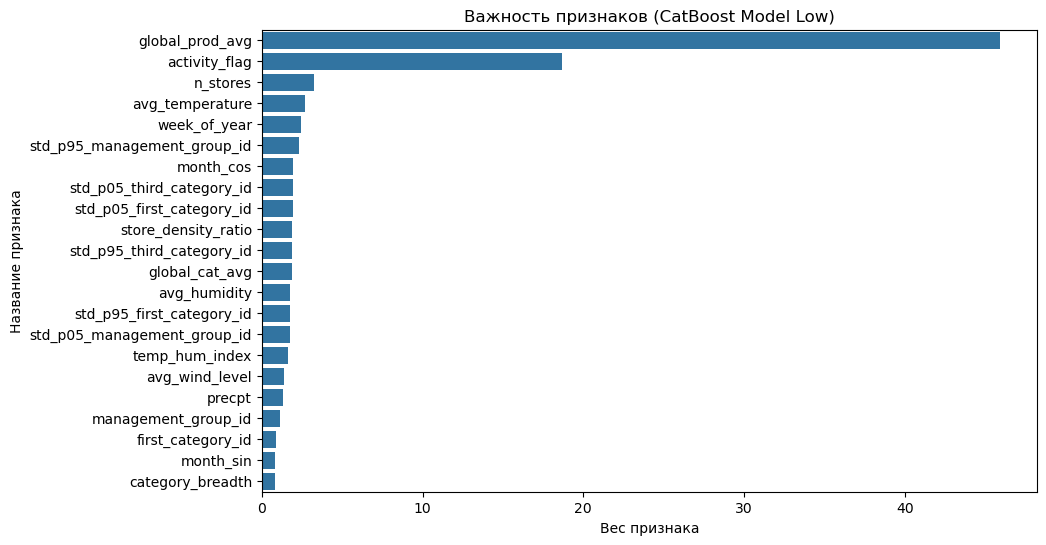

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()